# Bragg Reflector

The band structure of light propagating in vacuum is a straight line. This is the dispersion relation of light. What happens if we add a periodicity to our medium? At zone boundaries, the bands are continuous and we have band folding. If we create a periodic index profile (like a diffraction grating) and inject light with a fiber at a proper angle, a band gap can appear in the dispersion relation, where of course reflectance will be very high.  

If at some point i remove a layer (introducing a defect), a cavity appears and plays the role of a frequency filter. At this point we have 2 frequency with high reflectance in a given band forming our cavity. 

One can prove that the reflectance is maximised if

$$ d_{(1,2)} = \frac{\lambda_0}{4 n_{(1,2)}} $$

We will need a source and two monitors. In between, a certain number of periods of this structure $\approx 10$. If the number is odd, it is easy to create a symmetric defect. We need very wide monitors to avoid losses in our measurement. We need to leave some space (e.g. $5a$) between the monitors and the periodic stucture inside.

Good values are $n_1 = 1.45$, $n_2 = 2.9$, $f=0.645$, $df=0.5$. The width of the gap depends on the index contrast:

$$ \frac{\Delta\omega}{\omega} \propto \Delta n $$

In [1]:
# Import packages 

import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
import scipy.signal as sp
import scipy.stats as spst


-----------
Initializing structure...
time for choose_chunkdivision = 0.000432014 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 16
     block, center = (1.68667,0,0)
          size (5.37333,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.586667,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.173333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (0.24,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (0.653333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          diel

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 104.0/328.5714282989502 = 31.7% done in 4.0s, 8.6s to go
on time step 3341 (time=104.406), 0.00119747 s/step
Meep progress: 217.375/328.5714282989502 = 66.2% done in 8.0s, 4.1s to go
on time step 6971 (time=217.844), 0.00110234 s/step
run 0 finished at t = 328.59375 (10515 timesteps)


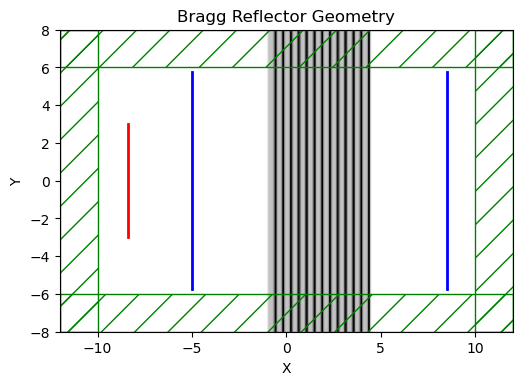

In [2]:
# Start by defining the simulation domain

sy = 16

res = 16

# Refractive index parameters

n_high = 2.5
n_low = 1.5
dpml = 2 

# Frequency parameters

wl = 1.55  
freq = 1 / wl 
df = 0.35
nfreq = 500


# Unit conversion parameters

a = 2 *1e-6 # Let us use this as a length scale
c = 2.99792548 *1e8 # Speed of light 
courant = 0.5 

f_conv = (c*courant*res) / a

# Layers 

l_high = wl / (4 * n_high) # This is 310 nm thick

l_low = wl / (4 * n_low) # and this is 516 nm

# These thicknesses seem reasonable.

period = l_high + l_low

n_p = 13

thck = n_p * period  # The whole thickness is  10.74 microns

space_front = 8
space_back = 4

sx = np.ceil(2 * dpml + space_front + space_back + thck + 2)
sy = 16

# Meep function to define the domain. 

cell = mp.Vector3(sx, sy)

# Now we define the geomtry. This has to be done iteratively. 1st layer at low index. 

# First, make a block of index n_low

geometry = [mp.Block(
           mp.Vector3(thck, mp.inf, mp.inf), #
           center = mp.Vector3((dpml + space_front + thck/2) - sx/2 +1,0,0),  
           material = mp.Medium(index = n_low)) ] 


for jj in range(0, n_p):
    
    geometry.append( 
        mp.Block(
           mp.Vector3(l_high, mp.inf, mp.inf), #
           center = mp.Vector3((dpml + space_front + (jj+1)*period) -sx/2 +1, 0,0),  
           material = mp.Medium(index = n_high))
    )



# Now define a source

sources = [mp.Source(mp.GaussianSource(frequency=freq, fwidth = df), # Type of source
                     component = mp.Ez, 
                     size = mp.Vector3(0,6,0),
                     center = mp.Vector3(-sx/2 + 1.8*dpml,0))] # Position

# Boundary condition, we use PML layer

pml_layer = [mp.PML(dpml) ] 

# Define Simulation

sim = mp.Simulation(
      cell_size = cell,
      boundary_layers = pml_layer,
      geometry = geometry,
      sources = sources,
      resolution = res)

# Define Flux region for Transmitted Field

tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 1.5, 0, 0), size = mp.Vector3(0,11.5,0) )
trans = sim.add_flux(freq, df, nfreq, tr_fr)

re_fr = mp.FluxRegion(center=mp.Vector3(-sx/2 + dpml + 5, 0, 0), size = mp.Vector3(0,11.5,0) )
refl = sim.add_flux(freq, df, nfreq, re_fr)


# Run Simulation

sim.run(until_after_sources=300) 
#sim.run(mp.at_every(10, mp.output_png(mp.Ez,"-Zc dkbluered")), until_after_sources=300) 

# Now Get Fluxes

straight_tr_fl = mp.get_fluxes(trans)
straight_re_fl = mp.get_fluxes(refl)
fl_fr = mp.get_flux_freqs(refl)

str_re_data = sim.get_flux_data(refl)

# plot the dielectric structure 

plt.figure(dpi=100)
sim.plot2D()
plt.title("Bragg Reflector Geometry")
plt.savefig("bragg_geom.png", dpi = 150, format = "png")
plt.show()


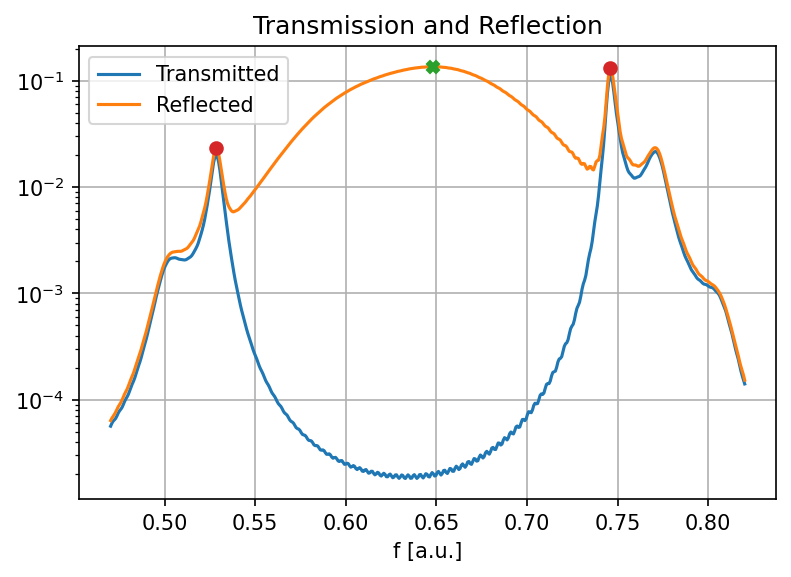

In [3]:
# Now we find delta omega / omega 

half = int(np.floor(len(straight_tr_fl)/2)) 

ind_inf = np.argmax(straight_tr_fl[0:half]) # first peak of transmission before reflection window

ind_min = ind_inf + np.argmin(straight_re_fl[ind_inf:half]) # minimum of reflection before reflection window

ind_sup = half + np.argmax(straight_tr_fl[half:]) # transmission peak after reflection window

ind_max = half + np.argmin(straight_re_fl[half:ind_sup]) # minimum of reflection after reflection window

# Find peak

peak_loc = ind_min + np.argmax(straight_re_fl[ind_min:ind_max]) 

pk = np.max(straight_re_fl[ind_min:ind_max]) 

# Find width

gap_width = fl_fr[ind_sup]-fl_fr[ind_inf]

# plot the fluxes

fig = plt.figure(dpi=150)

#fl_fr = np.array(fl_fr) * f_conv / 1e12

plt.plot(fl_fr, np.abs(straight_tr_fl), label="Transmitted")
plt.plot(fl_fr, np.abs(straight_re_fl), label ="Reflected")
plt.plot(fl_fr[ind_inf], np.abs(straight_re_fl)[ind_inf], "o", color= "C3") 
plt.plot(fl_fr[ind_sup], np.abs(straight_re_fl)[ind_sup], "o", color= "C3") 
plt.plot(fl_fr[peak_loc], np.abs(straight_re_fl)[peak_loc], "X" )
plt.yscale("log")
plt.legend()
plt.grid()
plt.xlabel("f [a.u.]")
plt.title("Transmission and Reflection")

plt.savefig("finding_peak.png", dpi = 150, format = "png")

plt.show()


# Study The Refractive Index Contrast Dependence

Change the index contrast and do the same simulation over and over 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000215054 s
Working in 2D dimensions.
Computational cell is 25 x 16 x 0 with resolution 14
     block, center = (1.50482,0,0)
          size (6.00965,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.03772,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (-0.575439,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (-0.113158,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0.349123,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 249.92857142857142/328.5714282989502 = 76.1% done in 4.0s, 1.3s to go
on time step 7006 (time=250.214), 0.000571009 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000246048 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.99634,0,0)
          size (5.99267,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.539025,0,0)
          size (0.202641,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.65668,3.65668,3.65668)
     block, center = (-0.0780505,0,0)
          size (0.202641,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.65668,3.65668,3.65668)
     block, center = (0.382924,0,0)
          size (0.202641,1e+20,1e+20)
     

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 253.89285714285714/328.5714282989502 = 77.3% done in 4.0s, 1.2s to go
on time step 7114 (time=254.071), 0.000562329 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000234127 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.98796,0,0)
          size (5.97591,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.540315,0,0)
          size (0.201352,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.70366,3.70366,3.70366)
     block, center = (-0.0806292,0,0)
          size (0.201352,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.70366,3.70366,3.70366)
     block, center = (0.379056,0,0)
          size (0.201352,1e+20,1e+20)
     

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 254.53571428571428/328.5714282989502 = 77.5% done in 4.0s, 1.2s to go
on time step 7140 (time=255), 0.00056041 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.97968,0,0)
          size (5.95936,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.541588,0,0)
          size (0.200079,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.75094,3.75094,3.75094)
     block, center = (-0.0831753,0,0)
          size (0.200079,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.75094,3.75094,3.75094)
     block, center = (0.375237,0,0)
          size (0.200079,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 221.78571428571428/328.5714282989502 = 67.5% done in 4.0s, 1.9s to go
on time step 6215 (time=221.964), 0.000643656 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000210047 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.97151,0,0)
          size (5.94302,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.542845,0,0)
          size (0.198822,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.79852,3.79852,3.79852)
     block, center = (-0.0856894,0,0)
          size (0.198822,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.79852,3.79852,3.79852)
     block, center = (0.371466,0,0)
          size (0.198822,1e+20,1e+20)
     

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 233.60714285714283/328.5714282989502 = 71.1% done in 4.0s, 1.6s to go
on time step 6555 (time=234.107), 0.0006104 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.96344,0,0)
          size (5.92688,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.544086,0,0)
          size (0.197581,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8464,3.8464,3.8464)
     block, center = (-0.088172,0,0)
          size (0.197581,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8464,3.8464,3.8464)
     block, center = (0.367742,0,0)
          size (0.197581,1e+20,1e+20)
          axes

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 259.60714285714283/328.5714282989502 = 79.0% done in 4.0s, 1.1s to go
on time step 7275 (time=259.821), 0.000549844 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.95547,0,0)
          size (5.91094,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.545312,0,0)
          size (0.196355,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.89458,3.89458,3.89458)
     block, center = (-0.0906239,0,0)
          size (0.196355,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.89458,3.89458,3.89458)
     block, center = (0.364064,0,0)
          size (0.196355,1e+20,1e+20)
     

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 271.6428571428571/328.5714282989502 = 82.7% done in 4.0s, 0.8s to go
on time step 7631 (time=272.536), 0.000524216 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000324965 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.9476,0,0)
          size (5.8952,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.546523,0,0)
          size (0.195144,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.94306,3.94306,3.94306)
     block, center = (-0.0930456,0,0)
          size (0.195144,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.94306,3.94306,3.94306)
     block, center = (0.360432,0,0)
          size (0.195144,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 275.5/328.5714282989502 = 83.8% done in 4.0s, 0.8s to go
on time step 7725 (time=275.893), 0.000517916 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231028 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.93983,0,0)
          size (5.87966,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.547719,0,0)
          size (0.193948,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.99184,3.99184,3.99184)
     block, center = (-0.0954375,0,0)
          size (0.193948,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.99184,3.99184,3.99184)
     block, center = (0.356844,0,0)
          size (0.193948,1e+20,1e+20)
          axes (1,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 300.07142857142856/328.5714282989502 = 91.3% done in 4.0s, 0.4s to go
on time step 8415 (time=300.536), 0.00047564 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000221968 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.93215,0,0)
          size (5.8643,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.5489,0,0)
          size (0.192766,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.04092,4.04092,4.04092)
     block, center = (-0.0978003,0,0)
          size (0.192766,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.04092,4.04092,4.04092)
     block, center = (0.353299,0,0)
          size (0.192766,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.35714285714283/328.5714282989502 = 91.1% done in 4.0s, 0.4s to go
on time step 8391 (time=299.679), 0.000476745 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000218153 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.92456,0,0)
          size (5.84913,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.550067,0,0)
          size (0.191599,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.0903,4.0903,4.0903)
     block, center = (-0.100135,0,0)
          size (0.191599,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.0903,4.0903,4.0903)
     block, center = (0.349798,0,0)
          size (0.191599,1e+20,1e+20)
          ax

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 298.3928571428571/328.5714282989502 = 90.8% done in 4.0s, 0.4s to go
on time step 8369 (time=298.893), 0.000477987 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000209093 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.91707,0,0)
          size (5.83414,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.55122,0,0)
          size (0.190446,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.13998,4.13998,4.13998)
     block, center = (-0.102441,0,0)
          size (0.190446,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.13998,4.13998,4.13998)
     block, center = (0.346339,0,0)
          size (0.190446,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 287.60714285714283/328.5714282989502 = 87.5% done in 4.0s, 0.6s to go
on time step 8065 (time=288.036), 0.00049602 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000339031 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.90966,0,0)
          size (5.81933,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.55236,0,0)
          size (0.189307,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.18996,4.18996,4.18996)
     block, center = (-0.104719,0,0)
          size (0.189307,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.18996,4.18996,4.18996)
     block, center = (0.342921,0,0)
          size (0.189307,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.9642857142857/328.5714282989502 = 91.3% done in 4.0s, 0.4s to go
on time step 8417 (time=300.607), 0.000475259 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000207901 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.90235,0,0)
          size (5.80469,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.553485,0,0)
          size (0.188181,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.24024,4.24024,4.24024)
     block, center = (-0.106971,0,0)
          size (0.188181,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.24024,4.24024,4.24024)
     block, center = (0.339544,0,0)
          size (0.188181,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 291.4642857142857/328.5714282989502 = 88.7% done in 4.0s, 0.5s to go
on time step 8175 (time=291.964), 0.00048949 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00023818 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.89511,0,0)
          size (5.79023,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.554598,0,0)
          size (0.187069,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.29082,4.29082,4.29082)
     block, center = (-0.109195,0,0)
          size (0.187069,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.29082,4.29082,4.29082)
     block, center = (0.336207,0,0)
          size (0.187069,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 295.32142857142856/328.5714282989502 = 89.9% done in 4.0s, 0.5s to go
on time step 8280 (time=295.714), 0.000483237 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000292063 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.88797,0,0)
          size (5.77594,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.555697,0,0)
          size (0.18597,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.3417,4.3417,4.3417)
     block, center = (-0.111394,0,0)
          size (0.18597,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.3417,4.3417,4.3417)
     block, center = (0.332909,0,0)
          size (0.18597,1e+20,1e+20)
          axes 

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 292.82142857142856/328.5714282989502 = 89.1% done in 4.0s, 0.5s to go
on time step 8206 (time=293.071), 0.000487493 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.88091,0,0)
          size (5.76181,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.556784,0,0)
          size (0.184883,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.39287,4.39287,4.39287)
     block, center = (-0.113567,0,0)
          size (0.184883,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.39287,4.39287,4.39287)
     block, center = (0.329649,0,0)
          size (0.184883,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 282.7857142857143/328.5714282989502 = 86.1% done in 4.0s, 0.6s to go
on time step 7925 (time=283.036), 0.000504734 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000320911 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.87393,0,0)
          size (5.74785,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.557857,0,0)
          size (0.183809,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.44435,4.44435,4.44435)
     block, center = (-0.115715,0,0)
          size (0.183809,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.44435,4.44435,4.44435)
     block, center = (0.326428,0,0)
          size (0.183809,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 284.2142857142857/328.5714282989502 = 86.5% done in 4.0s, 0.6s to go
on time step 7971 (time=284.679), 0.000501881 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000232935 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.86703,0,0)
          size (5.73406,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.558919,0,0)
          size (0.182748,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.49613,4.49613,4.49613)
     block, center = (-0.117838,0,0)
          size (0.182748,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.49613,4.49613,4.49613)
     block, center = (0.323244,0,0)
          size (0.182748,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 291.75/328.5714282989502 = 88.8% done in 4.0s, 0.5s to go
on time step 8188 (time=292.429), 0.000488522 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000226021 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.86021,0,0)
          size (5.72041,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.559968,0,0)
          size (0.181699,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.54821,4.54821,4.54821)
     block, center = (-0.119936,0,0)
          size (0.181699,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.54821,4.54821,4.54821)
     block, center = (0.320096,0,0)
          size (0.181699,1e+20,1e+20)
          axes (1,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 284.4285714285714/328.5714282989502 = 86.6% done in 4.0s, 0.6s to go
on time step 7980 (time=285), 0.000501421 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000358105 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.85346,0,0)
          size (5.70693,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.561005,0,0)
          size (0.180661,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.60059,4.60059,4.60059)
     block, center = (-0.122011,0,0)
          size (0.180661,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.60059,4.60059,4.60059)
     block, center = (0.316984,0,0)
          size (0.180661,1e+20,1e+20)
          a

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 280.2142857142857/328.5714282989502 = 85.3% done in 4.0s, 0.7s to go
on time step 7859 (time=280.679), 0.000509012 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000212908 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.8468,0,0)
          size (5.6936,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.562031,0,0)
          size (0.179636,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.65327,4.65327,4.65327)
     block, center = (-0.124062,0,0)
          size (0.179636,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.65327,4.65327,4.65327)
     block, center = (0.313907,0,0)
          size (0.179636,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 281.1428571428571/328.5714282989502 = 85.6% done in 4.0s, 0.7s to go
on time step 7883 (time=281.536), 0.000507422 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000207901 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.84021,0,0)
          size (5.68042,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.563045,0,0)
          size (0.178622,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.70624,4.70624,4.70624)
     block, center = (-0.12609,0,0)
          size (0.178622,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.70624,4.70624,4.70624)
     block, center = (0.310865,0,0)
          size (0.178622,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 296.25/328.5714282989502 = 90.2% done in 4.0s, 0.4s to go
on time step 8305 (time=296.607), 0.000481652 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000217915 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.83369,0,0)
          size (5.66738,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.564047,0,0)
          size (0.177619,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.75952,4.75952,4.75952)
     block, center = (-0.128095,0,0)
          size (0.177619,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.75952,4.75952,4.75952)
     block, center = (0.307858,0,0)
          size (0.177619,1e+20,1e+20)
          axes (1,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 262.57142857142856/328.5714282989502 = 79.9% done in 4.0s, 1.0s to go
on time step 7363 (time=262.964), 0.000543311 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000414133 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.82725,0,0)
          size (5.6545,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.565039,0,0)
          size (0.176628,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.8131,4.8131,4.8131)
     block, center = (-0.130078,0,0)
          size (0.176628,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.8131,4.8131,4.8131)
     block, center = (0.304884,0,0)
          size (0.176628,1e+20,1e+20)
          axe

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 244.10714285714283/328.5714282989502 = 74.3% done in 4.0s, 1.4s to go
on time step 6844 (time=244.429), 0.000584489 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000236988 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.82088,0,0)
          size (5.64175,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.566019,0,0)
          size (0.175648,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.86698,4.86698,4.86698)
     block, center = (-0.132038,0,0)
          size (0.175648,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.86698,4.86698,4.86698)
     block, center = (0.301943,0,0)
          size (0.175648,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 233.5/328.5714282989502 = 71.1% done in 4.0s, 1.6s to go
on time step 6550 (time=233.929), 0.000610724 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000221014 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.81457,0,0)
          size (5.62915,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.566989,0,0)
          size (0.174678,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.92115,4.92115,4.92115)
     block, center = (-0.133977,0,0)
          size (0.174678,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.92115,4.92115,4.92115)
     block, center = (0.299034,0,0)
          size (0.174678,1e+20,1e+20)
          axes (1,0

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 251.2142857142857/328.5714282989502 = 76.5% done in 4.0s, 1.2s to go
on time step 7045 (time=251.607), 0.000567806 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000309944 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.80834,0,0)
          size (5.61668,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.567948,0,0)
          size (0.173719,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.97563,4.97563,4.97563)
     block, center = (-0.135895,0,0)
          size (0.173719,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.97563,4.97563,4.97563)
     block, center = (0.296157,0,0)
          size (0.173719,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 293.0357142857143/328.5714282989502 = 89.2% done in 4.0s, 0.5s to go
on time step 8216 (time=293.429), 0.000486949 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000215054 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.80218,0,0)
          size (5.60435,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.568896,0,0)
          size (0.172771,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.03041,5.03041,5.03041)
     block, center = (-0.137792,0,0)
          size (0.172771,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.03041,5.03041,5.03041)
     block, center = (0.293312,0,0)
          size (0.172771,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 281.82142857142856/328.5714282989502 = 85.8% done in 4.0s, 0.7s to go
on time step 7902 (time=282.214), 0.000506215 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000203133 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.79608,0,0)
          size (5.59216,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.569834,0,0)
          size (0.171833,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.08549,5.08549,5.08549)
     block, center = (-0.139668,0,0)
          size (0.171833,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.08549,5.08549,5.08549)
     block, center = (0.290498,0,0)
          size (0.171833,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 286.57142857142856/328.5714282989502 = 87.2% done in 4.0s, 0.6s to go
on time step 8036 (time=287), 0.000497779 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000244141 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.79005,0,0)
          size (5.58009,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.570762,0,0)
          size (0.170905,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.14086,5.14086,5.14086)
     block, center = (-0.141524,0,0)
          size (0.170905,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.14086,5.14086,5.14086)
     block, center = (0.287714,0,0)
          size (0.170905,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 296.5357142857143/328.5714282989502 = 90.3% done in 4.0s, 0.4s to go
on time step 8311 (time=296.821), 0.000481291 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000225067 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.78408,0,0)
          size (5.56816,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.57168,0,0)
          size (0.169987,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.19654,5.19654,5.19654)
     block, center = (-0.14336,0,0)
          size (0.169987,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.19654,5.19654,5.19654)
     block, center = (0.28496,0,0)
          size (0.169987,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 306.7142857142857/328.5714282989502 = 93.3% done in 4.0s, 0.3s to go
on time step 8597 (time=307.036), 0.00046533 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000200987 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.77818,0,0)
          size (5.55635,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.572588,0,0)
          size (0.169078,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.25252,5.25252,5.25252)
     block, center = (-0.145177,0,0)
          size (0.169078,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.25252,5.25252,5.25252)
     block, center = (0.282235,0,0)
          size (0.169078,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 303.25/328.5714282989502 = 92.3% done in 4.0s, 0.3s to go
on time step 8499 (time=303.536), 0.000470665 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.77234,0,0)
          size (5.54467,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.573487,0,0)
          size (0.16818,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.30879,5.30879,5.30879)
     block, center = (-0.146974,0,0)
          size (0.16818,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.30879,5.30879,5.30879)
     block, center = (0.279539,0,0)
          size (0.16818,1e+20,1e+20)
          axes (1,0,0

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 285.5/328.5714282989502 = 86.9% done in 4.0s, 0.6s to go
on time step 8005 (time=285.893), 0.000499785 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000240088 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.76656,0,0)
          size (5.53311,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.574376,0,0)
          size (0.167291,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.36537,5.36537,5.36537)
     block, center = (-0.148752,0,0)
          size (0.167291,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.36537,5.36537,5.36537)
     block, center = (0.276872,0,0)
          size (0.167291,1e+20,1e+20)
          axes (1,0

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 300.0357142857143/328.5714282989502 = 91.3% done in 4.0s, 0.4s to go
on time step 8414 (time=300.5), 0.000475433 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000291824 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.76084,0,0)
          size (5.52168,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.575256,0,0)
          size (0.166411,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.42224,5.42224,5.42224)
     block, center = (-0.150511,0,0)
          size (0.166411,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.42224,5.42224,5.42224)
     block, center = (0.274233,0,0)
          size (0.166411,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 307.5/328.5714282989502 = 93.6% done in 4.0s, 0.3s to go
on time step 8622 (time=307.929), 0.000463993 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000196934 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.75518,0,0)
          size (5.51036,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.576126,0,0)
          size (0.165541,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.47942,5.47942,5.47942)
     block, center = (-0.152252,0,0)
          size (0.165541,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.47942,5.47942,5.47942)
     block, center = (0.271622,0,0)
          size (0.165541,1e+20,1e+20)
          axes (1,0

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 305.1428571428571/328.5714282989502 = 92.9% done in 4.0s, 0.3s to go
on time step 8554 (time=305.5), 0.000467651 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00019598 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.74958,0,0)
          size (5.49916,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.576988,0,0)
          size (0.164679,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.5369,5.5369,5.5369)
     block, center = (-0.153975,0,0)
          size (0.164679,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.5369,5.5369,5.5369)
     block, center = (0.269037,0,0)
          size (0.164679,1e+20,1e+20)
          axes (

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 298.9285714285714/328.5714282989502 = 91.0% done in 4.0s, 0.4s to go
on time step 8383 (time=299.393), 0.000477188 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000215054 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.74404,0,0)
          size (5.48808,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.57784,0,0)
          size (0.163827,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.59467,5.59467,5.59467)
     block, center = (-0.15568,0,0)
          size (0.163827,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.59467,5.59467,5.59467)
     block, center = (0.26648,0,0)
          size (0.163827,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 309.10714285714283/328.5714282989502 = 94.1% done in 4.0s, 0.3s to go
on time step 8670 (time=309.643), 0.000461425 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000212908 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.73856,0,0)
          size (5.47711,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.578684,0,0)
          size (0.162983,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.65275,5.65275,5.65275)
     block, center = (-0.157368,0,0)
          size (0.162983,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.65275,5.65275,5.65275)
     block, center = (0.263948,0,0)
          size (0.162983,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 293.60714285714283/328.5714282989502 = 89.4% done in 4.0s, 0.5s to go
on time step 8230 (time=293.929), 0.000486036 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.73313,0,0)
          size (5.46625,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.579519,0,0)
          size (0.162148,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.71112,5.71112,5.71112)
     block, center = (-0.159038,0,0)
          size (0.162148,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.71112,5.71112,5.71112)
     block, center = (0.261443,0,0)
          size (0.162148,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 298.9285714285714/328.5714282989502 = 91.0% done in 4.0s, 0.4s to go
on time step 8382 (time=299.357), 0.00047722 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000352859 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.72775,0,0)
          size (5.45551,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.580346,0,0)
          size (0.161321,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.7698,5.7698,5.7698)
     block, center = (-0.160691,0,0)
          size (0.161321,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.7698,5.7698,5.7698)
     block, center = (0.258963,0,0)
          size (0.161321,1e+20,1e+20)
          axes

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 287.5/328.5714282989502 = 87.5% done in 4.0s, 0.6s to go
on time step 8057 (time=287.75), 0.000496465 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.72244,0,0)
          size (5.44487,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.581164,0,0)
          size (0.160503,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.82878,5.82878,5.82878)
     block, center = (-0.162327,0,0)
          size (0.160503,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.82878,5.82878,5.82878)
     block, center = (0.256509,0,0)
          size (0.160503,1e+20,1e+20)
          axes (1,0,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 301.60714285714283/328.5714282989502 = 91.8% done in 4.0s, 0.4s to go
on time step 8449 (time=301.75), 0.000473456 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000229836 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.71717,0,0)
          size (5.43434,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.581974,0,0)
          size (0.159693,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.88805,5.88805,5.88805)
     block, center = (-0.163947,0,0)
          size (0.159693,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.88805,5.88805,5.88805)
     block, center = (0.254079,0,0)
          size (0.159693,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 301.9285714285714/328.5714282989502 = 91.9% done in 4.0s, 0.4s to go
on time step 8463 (time=302.25), 0.000472647 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000236034 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.71196,0,0)
          size (5.42392,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.582775,0,0)
          size (0.158891,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.94763,5.94763,5.94763)
     block, center = (-0.165551,0,0)
          size (0.158891,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.94763,5.94763,5.94763)
     block, center = (0.251674,0,0)
          size (0.158891,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 305.0357142857143/328.5714282989502 = 92.8% done in 4.0s, 0.3s to go
on time step 8560 (time=305.714), 0.000467329 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000198126 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.7068,0,0)
          size (5.4136,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.583569,0,0)
          size (0.158097,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0075,6.0075,6.0075)
     block, center = (-0.167138,0,0)
          size (0.158097,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0075,6.0075,6.0075)
     block, center = (0.249292,0,0)
          size (0.158097,1e+20,1e+20)
          axes 

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 304.3928571428571/328.5714282989502 = 92.6% done in 4.0s, 0.3s to go
on time step 8535 (time=304.821), 0.0004687 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.70169,0,0)
          size (5.40338,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.584355,0,0)
          size (0.157312,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.06768,6.06768,6.06768)
     block, center = (-0.16871,0,0)
          size (0.157312,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.06768,6.06768,6.06768)
     block, center = (0.246935,0,0)
          size (0.157312,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 295.2142857142857/328.5714282989502 = 89.8% done in 4.0s, 0.5s to go
on time step 8279 (time=295.679), 0.000483154 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00019598 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.69663,0,0)
          size (5.39327,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.585133,0,0)
          size (0.156533,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.12815,6.12815,6.12815)
     block, center = (-0.170267,0,0)
          size (0.156533,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.12815,6.12815,6.12815)
     block, center = (0.2446,0,0)
          size (0.156533,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.2142857142857/328.5714282989502 = 91.1% done in 4.0s, 0.4s to go
on time step 8385 (time=299.464), 0.000477075 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000208139 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.69163,0,0)
          size (5.38325,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.585904,0,0)
          size (0.155763,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.18893,6.18893,6.18893)
     block, center = (-0.171807,0,0)
          size (0.155763,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.18893,6.18893,6.18893)
     block, center = (0.242289,0,0)
          size (0.155763,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 310.75/328.5714282989502 = 94.6% done in 4.0s, 0.2s to go
on time step 8708 (time=311), 0.000459365 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000221968 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.68667,0,0)
          size (5.37333,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.586667,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.173333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (0.24,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          di

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 306.4285714285714/328.5714282989502 = 93.3% done in 4.0s, 0.3s to go
on time step 8596 (time=307), 0.000465353 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)


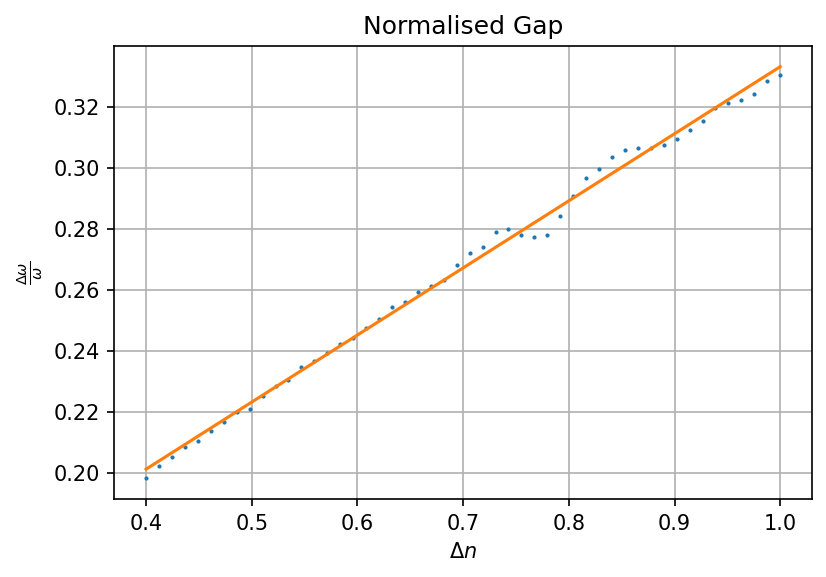

In [44]:
sim.reset_meep()

# NOTICE, IMPORTANT. THE MAXIMUM INDEX CONTRAST WE CAN USE IS LIMITED BY THE RESOLUTION WE CHOOSE
# FOR EXAMPLE, IF THE RESOLUTION IS 10 WE ARE LIMITED TO ABOUT 1 IN THE CONTRAST
# YOU COULD TRY TO UNDERSTAND WHY

# Refractive index parameters

nsize = 50
n_high_vec = np.linspace(1.9,2.5,nsize)
n_low = 1.5
dpml = 2 

# Frequency parameters

wl = 1.55
freq = 1 / wl
df = 0.35
nfreq = 500

# Now we start the geometry definition. This has to be done iteratively.

l_low = wl / (4 * n_low)

# Other things that do not depend on n_high

space_front = 8
space_back = 4

sy = 16
res = 14

# PML does not depend on n_high

pml_layer = [mp.PML(dpml) ] 


# Make a vector to store the result

norm_gap = np.zeros(len(n_high_vec))

# Now start with the n_high dependent part 

i = 0

for n_high in n_high_vec:
    
    # Layers 

    l_high = wl / (4 * n_high)

    period = l_high + l_low

    n_p = 13

    thck = n_p * period

    sx = np.ceil(2 * dpml + space_front + space_back + thck + 2)

    # Meep function to define the domain. 

    cell = mp.Vector3(sx, sy)
    
    # We start with the fixed block with index n_low
 

    geometry = [mp.Block(
               mp.Vector3(thck, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + thck/2) - sx/2 +1,0,0),  
               material = mp.Medium(index = n_low)) ] 

    # Now append the "stripes" of higher refractive index to the geometry 
    
    for jj in range(0, n_p):

        geometry.append( 
            mp.Block(
               mp.Vector3(l_high, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + (jj+1)*period) -sx/2 +1, 0,0),  
               material = mp.Medium(index = n_high))
        )
        
    #Source 

    sources = [mp.Source(mp.GaussianSource(frequency=freq, fwidth = df), # Type of source
                         component = mp.Ez, 
                         size = mp.Vector3(0,6,0),
                         center = mp.Vector3(-sx/2 + 1.8*dpml,0))] # Position

    # Define Simulation

    sim = mp.Simulation(
          cell_size = cell,
          boundary_layers = pml_layer,
          geometry = geometry,
          sources = sources,
          resolution = res)

    # Define Flux region for Transmitted Field

    tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 1.5, 0, 0), size = mp.Vector3(0,11.5,0) )
    trans = sim.add_flux(freq, df, nfreq, tr_fr)

    re_fr = mp.FluxRegion(center=mp.Vector3(-sx/2 + dpml + 5, 0, 0), size = mp.Vector3(0,11.5,0) )
    refl = sim.add_flux(freq, df, nfreq, re_fr)


    # Run Simulation

    sim.run(until_after_sources=300) 
    #sim.run(mp.at_every(10, mp.output_png(mp.Ez,"-Zc dkbluered")), until_after_sources=300) 

    # Now Get Fluxes

    straight_tr_fl = mp.get_fluxes(trans)
    straight_re_fl = mp.get_fluxes(refl)
    fl_fr = mp.get_flux_freqs(refl)

    str_re_data = sim.get_flux_data(refl)

    # Now we find delta omega / omega 

    half = int(np.floor(len(straight_tr_fl)/2)) 

    ind_inf = np.argmax(straight_tr_fl[0:half]) # first peak of transmission before reflection window

    ind_min = ind_inf + np.argmin(straight_re_fl[ind_inf:half]) # minimum of reflection before reflection window

    ind_sup = half + np.argmax(straight_tr_fl[half:]) # transmission peak after reflection window

    ind_max = half + np.argmin(straight_re_fl[half:ind_sup]) # minimum of reflection after reflection window

    # Find peak

    peak_loc = ind_min + np.argmax(straight_re_fl[ind_min:ind_max]) 

    pk = np.max(straight_re_fl[ind_min:ind_max]) 

    
    fwhm = fl_fr[ind_sup]-fl_fr[ind_inf]
    
    norm_gap[i] = fwhm / fl_fr[peak_loc]
 
    i += 1
    
# Now make a figure 

delta_n = n_high_vec - np.ones(len(n_high_vec)) * n_low

slope, intercept, r, p, se = spst.linregress(delta_n, norm_gap, alternative='greater')

fig, ax = plt.subplots(dpi=150)
ax.plot(delta_n, norm_gap, ".", markersize = 2)
ax.plot(delta_n, intercept + delta_n * slope)
ax.set_xlabel(r"$\Delta n$")
ax.set_ylabel(r"$\frac{\Delta\omega}{\omega}$")
plt.title("Normalised Gap")
plt.grid()
plt.savefig("gap_dependence_restricted.png", dpi = 150, format="png")
plt.show()

In [45]:
sim.reset_meep()

# NOTICE, IMPORTANT. THE MAXIMUM INDEX CONTRAST WE CAN USE IS LIMITED BY THE RESOLUTION WE CHOOSE
# FOR EXAMPLE, IF THE RESOLUTION IS 10 WE ARE LIMITED TO ABOUT 1 IN THE CONTRAST
# YOU COULD TRY TO UNDERSTAND WHY

# Refractive index parameters

nsize = 100
n_high_vec = np.linspace(1.9,3.6,nsize)
n_low = 1.5
dpml = 2 

# Frequency parameters

wl = 1.55
freq = 1 / wl
df = 0.35
nfreq = 500

# Now we start the geometry definition. This has to be done iteratively.

l_low = wl / (4 * n_low)

# Other things that do not depend on n_high

space_front = 8
space_back = 4

sy = 16
res = 14

# PML does not depend on n_high

pml_layer = [mp.PML(dpml) ] 


# Make a vector to store the result

norm_gap = np.zeros(len(n_high_vec))

# Now start with the n_high dependent part 

i = 0

for n_high in n_high_vec:
    
    # Layers 

    l_high = wl / (4 * n_high)

    period = l_high + l_low

    n_p = 13

    thck = n_p * period

    sx = np.ceil(2 * dpml + space_front + space_back + thck + 2)

    # Meep function to define the domain. 

    cell = mp.Vector3(sx, sy)
    
    # We start with the fixed block with index n_low
 

    geometry = [mp.Block(
               mp.Vector3(thck, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + thck/2) - sx/2 +1,0,0),  
               material = mp.Medium(index = n_low)) ] 

    # Now append the "stripes" of higher refractive index to the geometry 
    
    for jj in range(0, n_p):

        geometry.append( 
            mp.Block(
               mp.Vector3(l_high, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + (jj+1)*period) -sx/2 +1, 0,0),  
               material = mp.Medium(index = n_high))
        )
        
    #Source 

    sources = [mp.Source(mp.GaussianSource(frequency=freq, fwidth = df), # Type of source
                         component = mp.Ez, 
                         size = mp.Vector3(0,6,0),
                         center = mp.Vector3(-sx/2 + 1.8*dpml,0))] # Position

    # Define Simulation

    sim = mp.Simulation(
          cell_size = cell,
          boundary_layers = pml_layer,
          geometry = geometry,
          sources = sources,
          resolution = res)

    # Define Flux region for Transmitted Field

    tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 1.5, 0, 0), size = mp.Vector3(0,11.5,0) )
    trans = sim.add_flux(freq, df, nfreq, tr_fr)

    re_fr = mp.FluxRegion(center=mp.Vector3(-sx/2 + dpml + 5, 0, 0), size = mp.Vector3(0,11.5,0) )
    refl = sim.add_flux(freq, df, nfreq, re_fr)


    # Run Simulation

    sim.run(until_after_sources=300) 
    #sim.run(mp.at_every(10, mp.output_png(mp.Ez,"-Zc dkbluered")), until_after_sources=300) 

    # Now Get Fluxes

    straight_tr_fl = mp.get_fluxes(trans)
    straight_re_fl = mp.get_fluxes(refl)
    fl_fr = mp.get_flux_freqs(refl)

    str_re_data = sim.get_flux_data(refl)

    # Now we find delta omega / omega 

    half = int(np.floor(len(straight_tr_fl)/2)) 

    ind_inf = np.argmax(straight_tr_fl[0:half]) # first peak of transmission before reflection window

    ind_min = ind_inf + np.argmin(straight_re_fl[ind_inf:half]) # minimum of reflection before reflection window

    ind_sup = half + np.argmax(straight_tr_fl[half:]) # transmission peak after reflection window

    ind_max = half + np.argmin(straight_re_fl[half:ind_sup]) # minimum of reflection after reflection window

    # Find peak

    peak_loc = ind_min + np.argmax(straight_re_fl[ind_min:ind_max]) 

    pk = np.max(straight_re_fl[ind_min:ind_max]) 

    # Find width
    
    gap_width = fl_fr[ind_sup]-fl_fr[ind_inf]
    
    norm_gap[i] = gap_width / fl_fr[peak_loc]
 
    i += 1


-----------
Initializing structure...
time for choose_chunkdivision = 0.000213146 s
Working in 2D dimensions.
Computational cell is 25 x 16 x 0 with resolution 14
     block, center = (1.50482,0,0)
          size (6.00965,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.03772,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (-0.575439,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (-0.113158,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0.349123,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 289.5357142857143/328.5714282989502 = 88.1% done in 4.0s, 0.5s to go
on time step 8116 (time=289.857), 0.000492921 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000232935 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.99295,0,0)
          size (5.9859,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.539546,0,0)
          size (0.202121,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.67555,3.67555,3.67555)
     block, center = (-0.079092,0,0)
          size (0.202121,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.67555,3.67555,3.67555)
     block, center = (0.381362,0,0)
          size (0.202121,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.9642857142857/328.5714282989502 = 91.3% done in 4.0s, 0.4s to go
on time step 8412 (time=300.429), 0.00047556 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000224113 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.98129,0,0)
          size (5.96258,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.54134,0,0)
          size (0.200326,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.74168,3.74168,3.74168)
     block, center = (-0.0826806,0,0)
          size (0.200326,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.74168,3.74168,3.74168)
     block, center = (0.375979,0,0)
          size (0.200326,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 303.60714285714283/328.5714282989502 = 92.4% done in 4.0s, 0.3s to go
on time step 8510 (time=303.929), 0.000470179 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000385046 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.96983,0,0)
          size (5.93966,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.543103,0,0)
          size (0.198564,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.80841,3.80841,3.80841)
     block, center = (-0.086206,0,0)
          size (0.198564,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.80841,3.80841,3.80841)
     block, center = (0.370691,0,0)
          size (0.198564,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 300.9285714285714/328.5714282989502 = 91.6% done in 4.0s, 0.4s to go
on time step 8438 (time=301.357), 0.000474062 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.95857,0,0)
          size (5.91715,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.544835,0,0)
          size (0.196832,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.87573,3.87573,3.87573)
     block, center = (-0.0896699,0,0)
          size (0.196832,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.87573,3.87573,3.87573)
     block, center = (0.365495,0,0)
          size (0.196832,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 307.1428571428571/328.5714282989502 = 93.5% done in 4.0s, 0.3s to go
on time step 8622 (time=307.929), 0.000463968 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000209093 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.94751,0,0)
          size (5.89502,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.546537,0,0)
          size (0.19513,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.94363,3.94363,3.94363)
     block, center = (-0.0930739,0,0)
          size (0.19513,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.94363,3.94363,3.94363)
     block, center = (0.360389,0,0)
          size (0.19513,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 305.9642857142857/328.5714282989502 = 93.1% done in 4.0s, 0.3s to go
on time step 8587 (time=306.679), 0.000465832 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000209093 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.93664,0,0)
          size (5.87327,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.54821,0,0)
          size (0.193457,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.01213,4.01213,4.01213)
     block, center = (-0.0964196,0,0)
          size (0.193457,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.01213,4.01213,4.01213)
     block, center = (0.355371,0,0)
          size (0.193457,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 290.6785714285714/328.5714282989502 = 88.5% done in 4.0s, 0.5s to go
on time step 8147 (time=290.964), 0.00049103 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000210047 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.92595,0,0)
          size (5.8519,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.549854,0,0)
          size (0.191812,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.08122,4.08122,4.08122)
     block, center = (-0.0997083,0,0)
          size (0.191812,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.08122,4.08122,4.08122)
     block, center = (0.350437,0,0)
          size (0.191812,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 263.7142857142857/328.5714282989502 = 80.3% done in 4.0s, 1.0s to go
on time step 7394 (time=264.071), 0.000541023 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027585 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.91544,0,0)
          size (5.83088,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.551471,0,0)
          size (0.190196,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.15089,4.15089,4.15089)
     block, center = (-0.102942,0,0)
          size (0.190196,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.15089,4.15089,4.15089)
     block, center = (0.345588,0,0)
          size (0.190196,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 294.0357142857143/328.5714282989502 = 89.5% done in 4.0s, 0.5s to go
on time step 8247 (time=294.536), 0.000485031 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000229836 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.90511,0,0)
          size (5.81021,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.55306,0,0)
          size (0.188606,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.22116,4.22116,4.22116)
     block, center = (-0.106121,0,0)
          size (0.188606,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.22116,4.22116,4.22116)
     block, center = (0.340819,0,0)
          size (0.188606,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 275.07142857142856/328.5714282989502 = 83.7% done in 4.0s, 0.8s to go
on time step 7711 (time=275.393), 0.000518789 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000200987 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.89495,0,0)
          size (5.78989,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.554624,0,0)
          size (0.187043,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.29201,4.29201,4.29201)
     block, center = (-0.109248,0,0)
          size (0.187043,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.29201,4.29201,4.29201)
     block, center = (0.336129,0,0)
          size (0.187043,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 300.25/328.5714282989502 = 91.4% done in 4.0s, 0.4s to go
on time step 8421 (time=300.75), 0.000475054 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000211954 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.88495,0,0)
          size (5.7699,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.556161,0,0)
          size (0.185505,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.36346,4.36346,4.36346)
     block, center = (-0.112323,0,0)
          size (0.185505,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.36346,4.36346,4.36346)
     block, center = (0.331516,0,0)
          size (0.185505,1e+20,1e+20)
          axes (1,0,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.4642857142857/328.5714282989502 = 91.1% done in 4.0s, 0.4s to go
on time step 8393 (time=299.75), 0.000476592 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.87512,0,0)
          size (5.75024,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.557674,0,0)
          size (0.183993,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.43549,4.43549,4.43549)
     block, center = (-0.115348,0,0)
          size (0.183993,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.43549,4.43549,4.43549)
     block, center = (0.326978,0,0)
          size (0.183993,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 275.75/328.5714282989502 = 83.9% done in 4.0s, 0.8s to go
on time step 7728 (time=276), 0.000517602 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000241041 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.86545,0,0)
          size (5.7309,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.559162,0,0)
          size (0.182505,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.50812,4.50812,4.50812)
     block, center = (-0.118324,0,0)
          size (0.182505,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.50812,4.50812,4.50812)
     block, center = (0.322514,0,0)
          size (0.182505,1e+20,1e+20)
          axes (1,0,0),

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 284.07142857142856/328.5714282989502 = 86.5% done in 4.0s, 0.6s to go
on time step 7965 (time=284.464), 0.000502205 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.85593,0,0)
          size (5.71186,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.560626,0,0)
          size (0.181041,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.58133,4.58133,4.58133)
     block, center = (-0.121252,0,0)
          size (0.181041,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.58133,4.58133,4.58133)
     block, center = (0.318122,0,0)
          size (0.181041,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 282.5357142857143/328.5714282989502 = 86.0% done in 4.0s, 0.7s to go
on time step 7927 (time=283.107), 0.000504609 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000198126 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.84656,0,0)
          size (5.69313,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.562067,0,0)
          size (0.1796,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.65513,4.65513,4.65513)
     block, center = (-0.124134,0,0)
          size (0.1796,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.65513,4.65513,4.65513)
     block, center = (0.313799,0,0)
          size (0.1796,1e+20,1e+20)
          axe

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 297.32142857142856/328.5714282989502 = 90.5% done in 4.0s, 0.4s to go
on time step 8339 (time=297.821), 0.000479733 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000224113 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.83735,0,0)
          size (5.67469,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.563485,0,0)
          size (0.178182,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.72953,4.72953,4.72953)
     block, center = (-0.12697,0,0)
          size (0.178182,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.72953,4.72953,4.72953)
     block, center = (0.309545,0,0)
          size (0.178182,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 296.85714285714283/328.5714282989502 = 90.3% done in 4.0s, 0.4s to go
on time step 8324 (time=297.286), 0.000480581 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000207186 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.82827,0,0)
          size (5.65655,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.564881,0,0)
          size (0.176786,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.80451,4.80451,4.80451)
     block, center = (-0.129762,0,0)
          size (0.176786,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.80451,4.80451,4.80451)
     block, center = (0.305357,0,0)
          size (0.176786,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 292.7142857142857/328.5714282989502 = 89.1% done in 4.0s, 0.5s to go
on time step 8205 (time=293.036), 0.0004877 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000195026 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.81934,0,0)
          size (5.63868,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.566255,0,0)
          size (0.175412,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.88008,4.88008,4.88008)
     block, center = (-0.13251,0,0)
          size (0.175412,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.88008,4.88008,4.88008)
     block, center = (0.301235,0,0)
          size (0.175412,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 280.4285714285714/328.5714282989502 = 85.3% done in 4.0s, 0.7s to go
on time step 7868 (time=281), 0.000508397 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000209093 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.81055,0,0)
          size (5.62109,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.567608,0,0)
          size (0.174059,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.95625,4.95625,4.95625)
     block, center = (-0.135216,0,0)
          size (0.174059,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.95625,4.95625,4.95625)
     block, center = (0.297176,0,0)
          size (0.174059,1e+20,1e+20)
          a

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.7142857142857/328.5714282989502 = 91.2% done in 4.0s, 0.4s to go
on time step 8401 (time=300.036), 0.000476164 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.80189,0,0)
          size (5.60377,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.56894,0,0)
          size (0.172726,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.033,5.033,5.033)
     block, center = (-0.137881,0,0)
          size (0.172726,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.033,5.033,5.033)
     block, center = (0.293179,0,0)
          size (0.172726,1e+20,1e+20)
          axes (1,0,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 287.3928571428571/328.5714282989502 = 87.5% done in 4.0s, 0.6s to go
on time step 8058 (time=287.786), 0.000496477 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00022006 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.79336,0,0)
          size (5.58672,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.570252,0,0)
          size (0.171414,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.11034,5.11034,5.11034)
     block, center = (-0.140505,0,0)
          size (0.171414,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.11034,5.11034,5.11034)
     block, center = (0.289243,0,0)
          size (0.171414,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 290.4642857142857/328.5714282989502 = 88.4% done in 4.0s, 0.5s to go
on time step 8152 (time=291.143), 0.00049072 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000337124 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.78496,0,0)
          size (5.56992,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.571545,0,0)
          size (0.170122,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.18827,5.18827,5.18827)
     block, center = (-0.143089,0,0)
          size (0.170122,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.18827,5.18827,5.18827)
     block, center = (0.285366,0,0)
          size (0.170122,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 294.6428571428571/328.5714282989502 = 89.7% done in 4.0s, 0.5s to go
on time step 8265 (time=295.179), 0.000484008 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000197172 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.77669,0,0)
          size (5.55337,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.572818,0,0)
          size (0.168849,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.26679,5.26679,5.26679)
     block, center = (-0.145635,0,0)
          size (0.168849,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.26679,5.26679,5.26679)
     block, center = (0.281547,0,0)
          size (0.168849,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 302.9642857142857/328.5714282989502 = 92.2% done in 4.0s, 0.3s to go
on time step 8490 (time=303.214), 0.000471233 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000216007 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.76853,0,0)
          size (5.53707,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.574072,0,0)
          size (0.167595,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.3459,5.3459,5.3459)
     block, center = (-0.148143,0,0)
          size (0.167595,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.3459,5.3459,5.3459)
     block, center = (0.277785,0,0)
          size (0.167595,1e+20,1e+20)
          axe

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 298.7142857142857/328.5714282989502 = 90.9% done in 4.0s, 0.4s to go
on time step 8374 (time=299.071), 0.000477708 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000196218 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.7605,0,0)
          size (5.52101,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.575307,0,0)
          size (0.166359,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.42561,5.42561,5.42561)
     block, center = (-0.150614,0,0)
          size (0.166359,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.42561,5.42561,5.42561)
     block, center = (0.274078,0,0)
          size (0.166359,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 295.32142857142856/328.5714282989502 = 89.9% done in 4.0s, 0.5s to go
on time step 8283 (time=295.821), 0.000482952 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.75259,0,0)
          size (5.50518,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.576525,0,0)
          size (0.165142,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.5059,5.5059,5.5059)
     block, center = (-0.153049,0,0)
          size (0.165142,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.5059,5.5059,5.5059)
     block, center = (0.270426,0,0)
          size (0.165142,1e+20,1e+20)
          ax

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 270.7142857142857/328.5714282989502 = 82.4% done in 4.0s, 0.9s to go
on time step 7590 (time=271.071), 0.000527184 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000298023 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.74479,0,0)
          size (5.48958,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.577724,0,0)
          size (0.163942,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.58678,5.58678,5.58678)
     block, center = (-0.155449,0,0)
          size (0.163942,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.58678,5.58678,5.58678)
     block, center = (0.266827,0,0)
          size (0.163942,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 287.35714285714283/328.5714282989502 = 87.5% done in 4.0s, 0.6s to go
on time step 8058 (time=287.786), 0.000496443 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000313997 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.73711,0,0)
          size (5.47421,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.578907,0,0)
          size (0.16276,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.66825,5.66825,5.66825)
     block, center = (-0.157814,0,0)
          size (0.16276,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.66825,5.66825,5.66825)
     block, center = (0.26328,0,0)
          size (0.16276,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 291.7142857142857/328.5714282989502 = 88.8% done in 4.0s, 0.5s to go
on time step 8176 (time=292), 0.000489302 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.72953,0,0)
          size (5.45906,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.580072,0,0)
          size (0.161594,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.75031,5.75031,5.75031)
     block, center = (-0.160145,0,0)
          size (0.161594,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.75031,5.75031,5.75031)
     block, center = (0.259783,0,0)
          size (0.161594,1e+20,1e+20)
          a

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 290.9642857142857/328.5714282989502 = 88.6% done in 4.0s, 0.5s to go
on time step 8152 (time=291.143), 0.00049071 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000208139 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.72206,0,0)
          size (5.44412,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.581221,0,0)
          size (0.160445,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.83296,5.83296,5.83296)
     block, center = (-0.162442,0,0)
          size (0.160445,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.83296,5.83296,5.83296)
     block, center = (0.256336,0,0)
          size (0.160445,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 300.75/328.5714282989502 = 91.5% done in 4.0s, 0.4s to go
on time step 8430 (time=301.071), 0.000474539 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231028 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.7147,0,0)
          size (5.4294,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.582354,0,0)
          size (0.159313,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.9162,5.9162,5.9162)
     block, center = (-0.164708,0,0)
          size (0.159313,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.9162,5.9162,5.9162)
     block, center = (0.252938,0,0)
          size (0.159313,1e+20,1e+20)
          axes (1,0,0), (0

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 282.5/328.5714282989502 = 86.0% done in 4.0s, 0.7s to go
on time step 7927 (time=283.107), 0.000504625 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000213146 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.70744,0,0)
          size (5.41488,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.583471,0,0)
          size (0.158196,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.00003,6.00003,6.00003)
     block, center = (-0.166942,0,0)
          size (0.158196,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.00003,6.00003,6.00003)
     block, center = (0.249588,0,0)
          size (0.158196,1e+20,1e+20)
          axes (1,0

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 270.2857142857143/328.5714282989502 = 82.3% done in 4.0s, 0.9s to go
on time step 7577 (time=270.607), 0.000527966 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000222921 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.70028,0,0)
          size (5.40056,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.584572,0,0)
          size (0.157095,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.08444,6.08444,6.08444)
     block, center = (-0.169144,0,0)
          size (0.157095,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.08444,6.08444,6.08444)
     block, center = (0.246284,0,0)
          size (0.157095,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 280.7142857142857/328.5714282989502 = 85.4% done in 4.0s, 0.7s to go
on time step 7870 (time=281.071), 0.000508271 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000236034 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.69322,0,0)
          size (5.38644,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.585658,0,0)
          size (0.156009,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.16945,6.16945,6.16945)
     block, center = (-0.171316,0,0)
          size (0.156009,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.16945,6.16945,6.16945)
     block, center = (0.243026,0,0)
          size (0.156009,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 288.60714285714283/328.5714282989502 = 87.8% done in 4.0s, 0.6s to go
on time step 8097 (time=289.179), 0.000494029 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00019598 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.68626,0,0)
          size (5.37252,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.586729,0,0)
          size (0.154937,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25505,6.25505,6.25505)
     block, center = (-0.173459,0,0)
          size (0.154937,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25505,6.25505,6.25505)
     block, center = (0.239812,0,0)
          size (0.154937,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 290.0/328.5714282989502 = 88.3% done in 4.0s, 0.5s to go
on time step 8130 (time=290.357), 0.000492015 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000232935 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.67939,0,0)
          size (5.35878,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.587786,0,0)
          size (0.153881,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.34124,6.34124,6.34124)
     block, center = (-0.175572,0,0)
          size (0.153881,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.34124,6.34124,6.34124)
     block, center = (0.236643,0,0)
          size (0.153881,1e+20,1e+20)
          axes (1,0

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 290.8928571428571/328.5714282989502 = 88.5% done in 4.0s, 0.5s to go
on time step 8161 (time=291.464), 0.000490168 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.67262,0,0)
          size (5.34524,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.588828,0,0)
          size (0.152839,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.42802,6.42802,6.42802)
     block, center = (-0.177656,0,0)
          size (0.152839,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.42802,6.42802,6.42802)
     block, center = (0.233516,0,0)
          size (0.152839,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 293.10714285714283/328.5714282989502 = 89.2% done in 4.0s, 0.5s to go
on time step 8220 (time=293.571), 0.000486815 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000197172 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.66593,0,0)
          size (5.33187,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.589856,0,0)
          size (0.15181,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.51539,6.51539,6.51539)
     block, center = (-0.179712,0,0)
          size (0.15181,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.51539,6.51539,6.51539)
     block, center = (0.230431,0,0)
          size (0.15181,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 303.60714285714283/328.5714282989502 = 92.4% done in 4.0s, 0.3s to go
on time step 8510 (time=303.929), 0.000470057 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000216961 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.65934,0,0)
          size (5.31868,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.590871,0,0)
          size (0.150796,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.60334,6.60334,6.60334)
     block, center = (-0.181741,0,0)
          size (0.150796,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.60334,6.60334,6.60334)
     block, center = (0.227388,0,0)
          size (0.150796,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 300.8928571428571/328.5714282989502 = 91.6% done in 4.0s, 0.4s to go
on time step 8434 (time=301.214), 0.000474283 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00019598 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.65283,0,0)
          size (5.30567,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.591872,0,0)
          size (0.149795,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.69189,6.69189,6.69189)
     block, center = (-0.183743,0,0)
          size (0.149795,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.69189,6.69189,6.69189)
     block, center = (0.224385,0,0)
          size (0.149795,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 306.25/328.5714282989502 = 93.2% done in 4.0s, 0.3s to go
on time step 8583 (time=306.536), 0.000466065 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000226021 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.64641,0,0)
          size (5.29283,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.592859,0,0)
          size (0.148807,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.78103,6.78103,6.78103)
     block, center = (-0.185719,0,0)
          size (0.148807,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.78103,6.78103,6.78103)
     block, center = (0.221422,0,0)
          size (0.148807,1e+20,1e+20)
          axes (1,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.9285714285714/328.5714282989502 = 91.3% done in 4.0s, 0.4s to go
on time step 8412 (time=300.429), 0.000475513 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00037694 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.64008,0,0)
          size (5.28015,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.593834,0,0)
          size (0.147832,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.87075,6.87075,6.87075)
     block, center = (-0.187669,0,0)
          size (0.147832,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.87075,6.87075,6.87075)
     block, center = (0.218497,0,0)
          size (0.147832,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 283.6428571428571/328.5714282989502 = 86.3% done in 4.0s, 0.6s to go
on time step 7956 (time=284.143), 0.00050281 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000208855 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.63382,0,0)
          size (5.26765,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.594796,0,0)
          size (0.14687,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.96107,6.96107,6.96107)
     block, center = (-0.189593,0,0)
          size (0.14687,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.96107,6.96107,6.96107)
     block, center = (0.215611,0,0)
          size (0.14687,1e+20,1e+20)
          a

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 293.35714285714283/328.5714282989502 = 89.3% done in 4.0s, 0.5s to go
on time step 8237 (time=294.179), 0.000485657 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000207186 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.62765,0,0)
          size (5.2553,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.595746,0,0)
          size (0.145921,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.05198,7.05198,7.05198)
     block, center = (-0.191492,0,0)
          size (0.145921,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.05198,7.05198,7.05198)
     block, center = (0.212762,0,0)
          size (0.145921,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 280.0357142857143/328.5714282989502 = 85.2% done in 4.0s, 0.7s to go
on time step 7856 (time=280.571), 0.0005092 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.62156,0,0)
          size (5.24311,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.596684,0,0)
          size (0.144983,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.14347,7.14347,7.14347)
     block, center = (-0.193367,0,0)
          size (0.144983,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.14347,7.14347,7.14347)
     block, center = (0.209949,0,0)
          size (0.144983,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 287.57142857142856/328.5714282989502 = 87.5% done in 4.0s, 0.6s to go
on time step 8062 (time=287.929), 0.000496213 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000210047 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.61554,0,0)
          size (5.23108,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.597609,0,0)
          size (0.144057,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.23556,7.23556,7.23556)
     block, center = (-0.195218,0,0)
          size (0.144057,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.23556,7.23556,7.23556)
     block, center = (0.207172,0,0)
          size (0.144057,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 291.4285714285714/328.5714282989502 = 88.7% done in 4.0s, 0.5s to go
on time step 8167 (time=291.679), 0.000489831 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.6096,0,0)
          size (5.2192,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.598523,0,0)
          size (0.143144,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.32823,7.32823,7.32823)
     block, center = (-0.197046,0,0)
          size (0.143144,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.32823,7.32823,7.32823)
     block, center = (0.204431,0,0)
          size (0.143144,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 284.3928571428571/328.5714282989502 = 86.6% done in 4.0s, 0.6s to go
on time step 7971 (time=284.679), 0.000501844 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000442982 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.60374,0,0)
          size (5.20747,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.599425,0,0)
          size (0.142241,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.4215,7.4215,7.4215)
     block, center = (-0.198851,0,0)
          size (0.142241,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.4215,7.4215,7.4215)
     block, center = (0.201724,0,0)
          size (0.142241,1e+20,1e+20)
          axe

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 305.1785714285714/328.5714282989502 = 92.9% done in 4.0s, 0.3s to go
on time step 8564 (time=305.857), 0.000467109 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000275135 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.59794,0,0)
          size (5.19589,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.600316,0,0)
          size (0.14135,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.51535,7.51535,7.51535)
     block, center = (-0.200633,0,0)
          size (0.14135,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.51535,7.51535,7.51535)
     block, center = (0.199051,0,0)
          size (0.14135,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 288.35714285714283/328.5714282989502 = 87.8% done in 4.0s, 0.6s to go
on time step 8086 (time=288.786), 0.000494702 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000197172 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.59223,0,0)
          size (5.18445,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.601196,0,0)
          size (0.140471,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.6098,7.6098,7.6098)
     block, center = (-0.202392,0,0)
          size (0.140471,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.6098,7.6098,7.6098)
     block, center = (0.196412,0,0)
          size (0.140471,1e+20,1e+20)
          ax

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 292.0/328.5714282989502 = 88.9% done in 4.0s, 0.5s to go
on time step 8188 (time=292.429), 0.000488567 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000197172 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.58658,0,0)
          size (5.17315,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.602065,0,0)
          size (0.139602,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.70483,7.70483,7.70483)
     block, center = (-0.20413,0,0)
          size (0.139602,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.70483,7.70483,7.70483)
     block, center = (0.193805,0,0)
          size (0.139602,1e+20,1e+20)
          axes (1,0,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 286.2857142857143/328.5714282989502 = 87.1% done in 4.0s, 0.6s to go
on time step 8028 (time=286.714), 0.00049826 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.581,0,0)
          size (5.162,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.602923,0,0)
          size (0.138743,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.80045,7.80045,7.80045)
     block, center = (-0.205847,0,0)
          size (0.138743,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.80045,7.80045,7.80045)
     block, center = (0.19123,0,0)
          size (0.138743,1e+20,1e+20)
          axe

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 280.4642857142857/328.5714282989502 = 85.4% done in 4.0s, 0.7s to go
on time step 7861 (time=280.75), 0.000508872 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00019598 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.57549,0,0)
          size (5.15097,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.603771,0,0)
          size (0.137895,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.89667,7.89667,7.89667)
     block, center = (-0.207543,0,0)
          size (0.137895,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.89667,7.89667,7.89667)
     block, center = (0.188686,0,0)
          size (0.137895,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 302.6785714285714/328.5714282989502 = 92.1% done in 4.0s, 0.3s to go
on time step 8489 (time=303.179), 0.000471265 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.57004,0,0)
          size (5.14009,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.604609,0,0)
          size (0.137058,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.99347,7.99347,7.99347)
     block, center = (-0.209218,0,0)
          size (0.137058,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.99347,7.99347,7.99347)
     block, center = (0.186174,0,0)
          size (0.137058,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 278.8928571428571/328.5714282989502 = 84.9% done in 4.0s, 0.7s to go
on time step 7817 (time=279.179), 0.000511763 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000197172 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.56466,0,0)
          size (5.12933,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.605436,0,0)
          size (0.13623,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.09086,8.09086,8.09086)
     block, center = (-0.210872,0,0)
          size (0.13623,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.09086,8.09086,8.09086)
     block, center = (0.183691,0,0)
          size (0.13623,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 277.5/328.5714282989502 = 84.5% done in 4.0s, 0.7s to go
on time step 7785 (time=278.036), 0.000513875 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000212908 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.55935,0,0)
          size (5.1187,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.606254,0,0)
          size (0.135413,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.18885,8.18885,8.18885)
     block, center = (-0.212507,0,0)
          size (0.135413,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.18885,8.18885,8.18885)
     block, center = (0.181239,0,0)
          size (0.135413,1e+20,1e+20)
          axes (1,0,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 282.32142857142856/328.5714282989502 = 85.9% done in 4.0s, 0.7s to go
on time step 7920 (time=282.857), 0.000505176 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000200987 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.5541,0,0)
          size (5.1082,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.607061,0,0)
          size (0.134605,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.28742,8.28742,8.28742)
     block, center = (-0.214123,0,0)
          size (0.134605,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.28742,8.28742,8.28742)
     block, center = (0.178816,0,0)
          size (0.134605,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 244.75/328.5714282989502 = 74.5% done in 4.0s, 1.4s to go
on time step 6858 (time=244.929), 0.000583268 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000208139 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.54891,0,0)
          size (5.09783,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.60786,0,0)
          size (0.133807,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.38658,8.38658,8.38658)
     block, center = (-0.215719,0,0)
          size (0.133807,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.38658,8.38658,8.38658)
     block, center = (0.176421,0,0)
          size (0.133807,1e+20,1e+20)
          axes (1,0

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 282.82142857142856/328.5714282989502 = 86.1% done in 4.0s, 0.6s to go
on time step 7935 (time=283.393), 0.000504205 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000197887 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.54379,0,0)
          size (5.08757,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.608648,0,0)
          size (0.133018,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.48633,8.48633,8.48633)
     block, center = (-0.217297,0,0)
          size (0.133018,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.48633,8.48633,8.48633)
     block, center = (0.174055,0,0)
          size (0.133018,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 304.82142857142856/328.5714282989502 = 92.8% done in 4.0s, 0.3s to go
on time step 8548 (time=305.286), 0.000467961 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243902 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.53872,0,0)
          size (5.07744,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.609428,0,0)
          size (0.132239,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.58668,8.58668,8.58668)
     block, center = (-0.218856,0,0)
          size (0.132239,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.58668,8.58668,8.58668)
     block, center = (0.171717,0,0)
          size (0.132239,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 297.8928571428571/328.5714282989502 = 90.7% done in 4.0s, 0.4s to go
on time step 8351 (time=298.25), 0.000478996 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000207186 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.53371,0,0)
          size (5.06742,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.610198,0,0)
          size (0.131468,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.68761,8.68761,8.68761)
     block, center = (-0.220396,0,0)
          size (0.131468,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.68761,8.68761,8.68761)
     block, center = (0.169405,0,0)
          size (0.131468,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 277.9285714285714/328.5714282989502 = 84.6% done in 4.0s, 0.7s to go
on time step 7790 (time=278.214), 0.000513479 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000226021 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.52876,0,0)
          size (5.05752,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.61096,0,0)
          size (0.130707,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.78913,8.78913,8.78913)
     block, center = (-0.221919,0,0)
          size (0.130707,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.78913,8.78913,8.78913)
     block, center = (0.167121,0,0)
          size (0.130707,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 285.2142857142857/328.5714282989502 = 86.8% done in 4.0s, 0.6s to go
on time step 8003 (time=285.821), 0.000499832 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000395775 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.52387,0,0)
          size (5.04774,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.611712,0,0)
          size (0.129954,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.89124,8.89124,8.89124)
     block, center = (-0.223425,0,0)
          size (0.129954,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.89124,8.89124,8.89124)
     block, center = (0.164863,0,0)
          size (0.129954,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 224.64285714285714/328.5714282989502 = 68.4% done in 4.0s, 1.9s to go
on time step 6300 (time=225), 0.000635355 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.51903,0,0)
          size (5.03807,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.612456,0,0)
          size (0.12921,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.99394,8.99394,8.99394)
     block, center = (-0.224913,0,0)
          size (0.12921,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.99394,8.99394,8.99394)
     block, center = (0.162631,0,0)
          size (0.12921,1e+20,1e+20)
          axe

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 255.17857142857142/328.5714282989502 = 77.7% done in 4.0s, 1.2s to go
on time step 7161 (time=255.75), 0.000558614 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.51425,0,0)
          size (5.0285,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.613192,0,0)
          size (0.128475,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.09723,9.09723,9.09723)
     block, center = (-0.226384,0,0)
          size (0.128475,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.09723,9.09723,9.09723)
     block, center = (0.160424,0,0)
          size (0.128475,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 264.7142857142857/328.5714282989502 = 80.6% done in 4.0s, 1.0s to go
on time step 7425 (time=265.179), 0.000538856 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.50952,0,0)
          size (5.01905,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.613919,0,0)
          size (0.127747,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.20111,9.20111,9.20111)
     block, center = (-0.227839,0,0)
          size (0.127747,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.20111,9.20111,9.20111)
     block, center = (0.158242,0,0)
          size (0.127747,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 294.25/328.5714282989502 = 89.6% done in 4.0s, 0.5s to go
on time step 8251 (time=294.679), 0.00048484 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.50485,0,0)
          size (5.0097,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.614639,0,0)
          size (0.127028,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.30558,9.30558,9.30558)
     block, center = (-0.229277,0,0)
          size (0.127028,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.30558,9.30558,9.30558)
     block, center = (0.156084,0,0)
          size (0.127028,1e+20,1e+20)
          axes (1,0,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 295.2857142857143/328.5714282989502 = 89.9% done in 4.0s, 0.5s to go
on time step 8280 (time=295.714), 0.0004832 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.50023,0,0)
          size (5.00046,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.61535,0,0)
          size (0.126317,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.41064,9.41064,9.41064)
     block, center = (-0.230699,0,0)
          size (0.126317,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.41064,9.41064,9.41064)
     block, center = (0.153951,0,0)
          size (0.126317,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 294.1428571428571/328.5714282989502 = 89.5% done in 4.0s, 0.5s to go
on time step 8250 (time=294.643), 0.00048499 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000197887 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.99566,0,0)
          size (4.99131,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.116053,0,0)
          size (0.125614,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.51629,9.51629,9.51629)
     block, center = (0.267895,0,0)
          size (0.125614,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.51629,9.51629,9.51629)
     block, center = (0.651842,0,0)
          size (0.125614,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 289.6428571428571/328.5714282989502 = 88.2% done in 4.0s, 0.5s to go
on time step 8125 (time=290.179), 0.000492351 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000197887 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.99114,0,0)
          size (4.98228,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.116748,0,0)
          size (0.124919,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.62253,9.62253,9.62253)
     block, center = (0.266504,0,0)
          size (0.124919,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.62253,9.62253,9.62253)
     block, center = (0.649756,0,0)
          size (0.124919,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 302.35714285714283/328.5714282989502 = 92.0% done in 4.0s, 0.3s to go
on time step 8477 (time=302.75), 0.00047191 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.98667,0,0)
          size (4.97333,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.117436,0,0)
          size (0.124231,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.72936,9.72936,9.72936)
     block, center = (0.265128,0,0)
          size (0.124231,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.72936,9.72936,9.72936)
     block, center = (0.647693,0,0)
          size (0.124231,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 300.10714285714283/328.5714282989502 = 91.3% done in 4.0s, 0.4s to go
on time step 8419 (time=300.679), 0.00047512 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000226021 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.98225,0,0)
          size (4.96449,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.118116,0,0)
          size (0.123551,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.83678,9.83678,9.83678)
     block, center = (0.263768,0,0)
          size (0.123551,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.83678,9.83678,9.83678)
     block, center = (0.645652,0,0)
          size (0.123551,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 300.25/328.5714282989502 = 91.4% done in 4.0s, 0.4s to go
on time step 8419 (time=300.679), 0.00047513 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.97787,0,0)
          size (4.95575,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.118789,0,0)
          size (0.122878,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.94479,9.94479,9.94479)
     block, center = (0.262423,0,0)
          size (0.122878,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.94479,9.94479,9.94479)
     block, center = (0.643634,0,0)
          size (0.122878,1e+20,1e+20)
          axes (1,0,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 266.7857142857143/328.5714282989502 = 81.2% done in 4.0s, 0.9s to go
on time step 7482 (time=267.214), 0.000534658 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000209808 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.97355,0,0)
          size (4.9471,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.119454,0,0)
          size (0.122212,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.0534,10.0534,10.0534)
     block, center = (0.261092,0,0)
          size (0.122212,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.0534,10.0534,10.0534)
     block, center = (0.641637,0,0)
          size (0.122212,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 234.78571428571428/328.5714282989502 = 71.5% done in 4.0s, 1.6s to go
on time step 6585 (time=235.179), 0.000607756 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.96927,0,0)
          size (4.93854,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.120112,0,0)
          size (0.121554,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.1626,10.1626,10.1626)
     block, center = (0.259775,0,0)
          size (0.121554,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.1626,10.1626,10.1626)
     block, center = (0.639663,0,0)
          size (0.121554,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 271.60714285714283/328.5714282989502 = 82.7% done in 4.0s, 0.8s to go
on time step 7622 (time=272.214), 0.00052483 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000213861 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.96504,0,0)
          size (4.93007,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.120764,0,0)
          size (0.120903,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.2723,10.2723,10.2723)
     block, center = (0.258473,0,0)
          size (0.120903,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.2723,10.2723,10.2723)
     block, center = (0.637709,0,0)
          size (0.120903,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 270.5357142857143/328.5714282989502 = 82.3% done in 4.0s, 0.9s to go
on time step 7585 (time=270.893), 0.000527364 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000241995 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.96085,0,0)
          size (4.9217,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.121408,0,0)
          size (0.120259,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.3827,10.3827,10.3827)
     block, center = (0.257184,0,0)
          size (0.120259,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.3827,10.3827,10.3827)
     block, center = (0.635776,0,0)
          size (0.120259,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 293.85714285714283/328.5714282989502 = 89.4% done in 4.0s, 0.5s to go
on time step 8237 (time=294.179), 0.000485617 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000194788 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.9567,0,0)
          size (4.91341,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.122046,0,0)
          size (0.119621,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.4937,10.4937,10.4937)
     block, center = (0.255909,0,0)
          size (0.119621,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.4937,10.4937,10.4937)
     block, center = (0.633863,0,0)
          size (0.119621,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 296.35714285714283/328.5714282989502 = 90.2% done in 4.0s, 0.4s to go
on time step 8308 (time=296.714), 0.000481526 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268221 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.9526,0,0)
          size (4.90521,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.122676,0,0)
          size (0.11899,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.6052,10.6052,10.6052)
     block, center = (0.254647,0,0)
          size (0.11899,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.6052,10.6052,10.6052)
     block, center = (0.631971,0,0)
          size (0.11899,1e+20,1e+20)
          a

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 308.57142857142856/328.5714282989502 = 93.9% done in 4.0s, 0.3s to go
on time step 8652 (time=309), 0.000462362 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000212908 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.94855,0,0)
          size (4.89709,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.1233,0,0)
          size (0.118366,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.7174,10.7174,10.7174)
     block, center = (0.253399,0,0)
          size (0.118366,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.7174,10.7174,10.7174)
     block, center = (0.630099,0,0)
          size (0.118366,1e+20,1e+20)
          axe

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 293.57142857142856/328.5714282989502 = 89.3% done in 4.0s, 0.5s to go
on time step 8234 (time=294.071), 0.000485806 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000368834 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.94453,0,0)
          size (4.88907,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.123918,0,0)
          size (0.117749,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.8301,10.8301,10.8301)
     block, center = (0.252164,0,0)
          size (0.117749,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.8301,10.8301,10.8301)
     block, center = (0.628246,0,0)
          size (0.117749,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 274.32142857142856/328.5714282989502 = 83.5% done in 4.0s, 0.8s to go
on time step 7696 (time=274.857), 0.000519765 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.0002141 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.94056,0,0)
          size (4.88112,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.124529,0,0)
          size (0.117137,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.9434,10.9434,10.9434)
     block, center = (0.250941,0,0)
          size (0.117137,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.9434,10.9434,10.9434)
     block, center = (0.626412,0,0)
          size (0.117137,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 298.8928571428571/328.5714282989502 = 91.0% done in 4.0s, 0.4s to go
on time step 8377 (time=299.179), 0.000477523 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000232935 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.93663,0,0)
          size (4.87326,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.125134,0,0)
          size (0.116533,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.0573,11.0573,11.0573)
     block, center = (0.249732,0,0)
          size (0.116533,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.0573,11.0573,11.0573)
     block, center = (0.624598,0,0)
          size (0.116533,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 275.6785714285714/328.5714282989502 = 83.9% done in 4.0s, 0.8s to go
on time step 7728 (time=276), 0.000517633 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000194788 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.93274,0,0)
          size (4.86547,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.125733,0,0)
          size (0.115934,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.1718,11.1718,11.1718)
     block, center = (0.248534,0,0)
          size (0.115934,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.1718,11.1718,11.1718)
     block, center = (0.622801,0,0)
          size (0.115934,1e+20,1e+20)
          ax

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 306.5357142857143/328.5714282989502 = 93.3% done in 4.0s, 0.3s to go
on time step 8591 (time=306.821), 0.000465618 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000216007 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.92888,0,0)
          size (4.85777,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.126325,0,0)
          size (0.115341,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.2869,11.2869,11.2869)
     block, center = (0.247349,0,0)
          size (0.115341,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.2869,11.2869,11.2869)
     block, center = (0.621024,0,0)
          size (0.115341,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 292.5357142857143/328.5714282989502 = 89.0% done in 4.0s, 0.5s to go
on time step 8201 (time=292.893), 0.000487751 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000209093 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.92507,0,0)
          size (4.85014,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.126912,0,0)
          size (0.114755,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.4026,11.4026,11.4026)
     block, center = (0.246176,0,0)
          size (0.114755,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.4026,11.4026,11.4026)
     block, center = (0.619264,0,0)
          size (0.114755,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 291.85714285714283/328.5714282989502 = 88.8% done in 4.0s, 0.5s to go
on time step 8183 (time=292.25), 0.000488956 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000210047 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.9213,0,0)
          size (4.8426,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.127493,0,0)
          size (0.114174,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.5188,11.5188,11.5188)
     block, center = (0.245015,0,0)
          size (0.114174,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.5188,11.5188,11.5188)
     block, center = (0.617522,0,0)
          size (0.114174,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 296.32142857142856/328.5714282989502 = 90.2% done in 4.0s, 0.4s to go
on time step 8309 (time=296.75), 0.00048144 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00020504 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.91756,0,0)
          size (4.83512,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.128067,0,0)
          size (0.113599,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.6357,11.6357,11.6357)
     block, center = (0.243865,0,0)
          size (0.113599,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.6357,11.6357,11.6357)
     block, center = (0.615798,0,0)
          size (0.113599,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 266.7142857142857/328.5714282989502 = 81.2% done in 4.0s, 0.9s to go
on time step 7477 (time=267.036), 0.00053505 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00019598 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.91386,0,0)
          size (4.82773,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.128636,0,0)
          size (0.11303,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.7531,11.7531,11.7531)
     block, center = (0.242727,0,0)
          size (0.11303,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.7531,11.7531,11.7531)
     block, center = (0.614091,0,0)
          size (0.11303,1e+20,1e+20)
          axe

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 308.9285714285714/328.5714282989502 = 94.0% done in 4.0s, 0.3s to go
on time step 8661 (time=309.321), 0.000461861 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00020504 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.9102,0,0)
          size (4.8204,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.1292,0,0)
          size (0.112467,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8712,11.8712,11.8712)
     block, center = (0.241601,0,0)
          size (0.112467,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8712,11.8712,11.8712)
     block, center = (0.612401,0,0)
          size (0.112467,1e+20,1e+20)
          axe

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.57142857142856/328.5714282989502 = 91.2% done in 4.0s, 0.4s to go
on time step 8403 (time=300.107), 0.00047604 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000204086 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.90658,0,0)
          size (4.81315,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.129757,0,0)
          size (0.111909,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9898,11.9898,11.9898)
     block, center = (0.240485,0,0)
          size (0.111909,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9898,11.9898,11.9898)
     block, center = (0.610728,0,0)
          size (0.111909,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 309.1428571428571/328.5714282989502 = 94.1% done in 4.0s, 0.3s to go
on time step 8669 (time=309.607), 0.000461467 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000195026 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.90299,0,0)
          size (4.80597,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.13031,0,0)
          size (0.111357,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.109,12.109,12.109)
     block, center = (0.239381,0,0)
          size (0.111357,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.109,12.109,12.109)
     block, center = (0.609071,0,0)
          size (0.111357,1e+20,1e+20)
          axes 

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.2857142857143/328.5714282989502 = 91.1% done in 4.0s, 0.4s to go
on time step 8396 (time=299.857), 0.000476444 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000198841 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.89943,0,0)
          size (4.79887,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.130856,0,0)
          size (0.11081,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.2288,12.2288,12.2288)
     block, center = (0.238287,0,0)
          size (0.11081,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.2288,12.2288,12.2288)
     block, center = (0.607431,0,0)
          size (0.11081,1e+20,1e+20)
          a

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 288.10714285714283/328.5714282989502 = 87.7% done in 4.0s, 0.6s to go
on time step 8079 (time=288.536), 0.00049513 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000224113 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.89591,0,0)
          size (4.79183,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.131398,0,0)
          size (0.110269,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.3492,12.3492,12.3492)
     block, center = (0.237204,0,0)
          size (0.110269,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.3492,12.3492,12.3492)
     block, center = (0.605806,0,0)
          size (0.110269,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 291.8928571428571/328.5714282989502 = 88.8% done in 4.0s, 0.5s to go
on time step 8183 (time=292.25), 0.000488838 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.89243,0,0)
          size (4.78486,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.131934,0,0)
          size (0.109733,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.4702,12.4702,12.4702)
     block, center = (0.236132,0,0)
          size (0.109733,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.4702,12.4702,12.4702)
     block, center = (0.604198,0,0)
          size (0.109733,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 281.9642857142857/328.5714282989502 = 85.8% done in 4.0s, 0.7s to go
on time step 7908 (time=282.429), 0.00050582 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000234842 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.88898,0,0)
          size (4.77795,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.132465,0,0)
          size (0.109202,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.5917,12.5917,12.5917)
     block, center = (0.23507,0,0)
          size (0.109202,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.5917,12.5917,12.5917)
     block, center = (0.602605,0,0)
          size (0.109202,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 297.1428571428571/328.5714282989502 = 90.4% done in 4.0s, 0.4s to go
on time step 8328 (time=297.429), 0.000480309 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00019598 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.88556,0,0)
          size (4.77112,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.132991,0,0)
          size (0.108676,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.7139,12.7139,12.7139)
     block, center = (0.234018,0,0)
          size (0.108676,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.7139,12.7139,12.7139)
     block, center = (0.601027,0,0)
          size (0.108676,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 283.4642857142857/328.5714282989502 = 86.3% done in 4.0s, 0.6s to go
on time step 7954 (time=284.071), 0.000502908 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000219107 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.88217,0,0)
          size (4.76435,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.133512,0,0)
          size (0.108155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.8367,12.8367,12.8367)
     block, center = (0.232976,0,0)
          size (0.108155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.8367,12.8367,12.8367)
     block, center = (0.599464,0,0)
          size (0.108155,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 291.5357142857143/328.5714282989502 = 88.7% done in 4.0s, 0.5s to go
on time step 8171 (time=291.821), 0.000489548 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000195026 s
Working in 2D dimensions.
Computational cell is 23 x 16 x 0 with resolution 14
     block, center = (1.87882,0,0)
          size (4.75764,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.134028,0,0)
          size (0.107639,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
     block, center = (0.231944,0,0)
          size (0.107639,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
     block, center = (0.597917,0,0)
          size (0.107639,1e+20,1e+20)
          axes (1,0,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 278.07142857142856/328.5714282989502 = 84.6% done in 4.0s, 0.7s to go
on time step 7800 (time=278.571), 0.00051298 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)


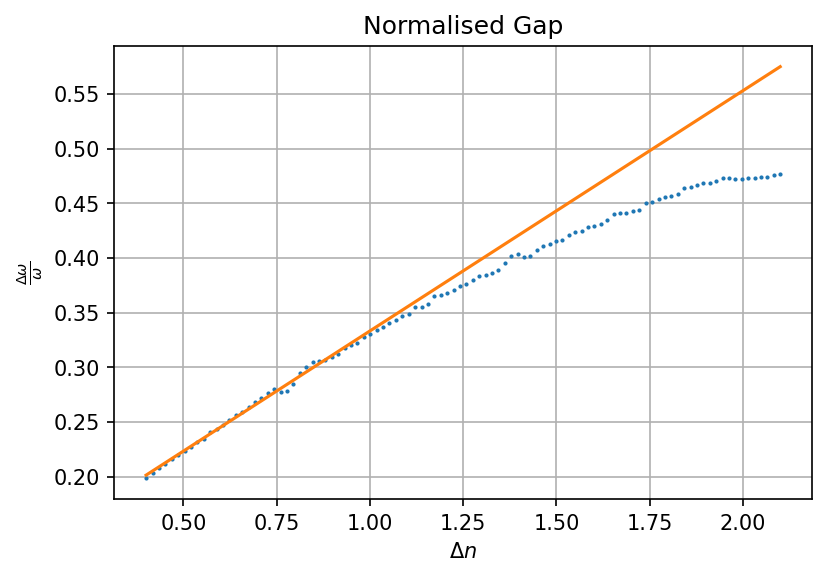

In [46]:
# Now make a figure 

delta_n = n_high_vec - np.ones(len(n_high_vec)) * n_low


fig, ax = plt.subplots(dpi=150)

ax.plot(delta_n, norm_gap, ".", markersize = 2)
ax.plot(delta_n, intercept + delta_n * slope)
ax.set_xlabel(r"$\Delta n$")
ax.set_ylabel(r"$\frac{\Delta\omega}{\omega}$")
plt.title("Normalised Gap")
plt.grid()
plt.savefig("gap_dependence.png", dpi = 150, format="png")

plt.show()


# Now make the simulation with the defect inside

-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 16
     block, center = (1.68667,0,0)
          size (5.37333,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.586667,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (-0.173333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (0.24,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (0.653333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          diel

FloatProgress(value=0.0, description='0% done ', max=428.5714282989502)

Meep progress: 190.625/428.5714282989502 = 44.5% done in 4.0s, 5.0s to go
on time step 6107 (time=190.844), 0.000655152 s/step
Meep progress: 379.46875/428.5714282989502 = 88.5% done in 8.0s, 1.0s to go
on time step 12152 (time=379.75), 0.00066179 s/step
run 0 finished at t = 428.59375 (13715 timesteps)


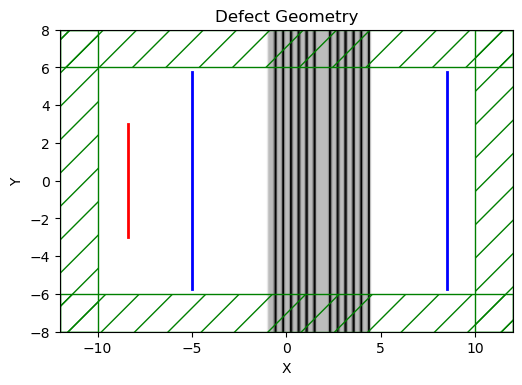

In [4]:
# First, reset meep 

sim.reset_meep()

n_low = 1.5
n_high = 2.4

# Now we define the geomtry. This has to be done iteratively. 1st layer at low index. 

# First, make a block of index n_low

resolution = 18

geometry = [mp.Block(
           mp.Vector3(thck, mp.inf, mp.inf), #
           center = mp.Vector3((dpml + space_front + thck/2) - sx/2 +1,0,0),  
           material = mp.Medium(index = n_low)) ] 


for jj in range(0, n_p):
    
    if jj != 6 : 
    
        geometry.append( 
            mp.Block(
               mp.Vector3(l_high, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + (jj+1)*period) -sx/2 +1, 0,0),  
               material = mp.Medium(index = n_high))
        )



# Now define a source

sources = [mp.Source(mp.GaussianSource(frequency=freq, fwidth = df), # Type of source
                     component = mp.Ez, 
                     size = mp.Vector3(0,6,0),
                     center = mp.Vector3(-sx/2 + 1.8*dpml,0))] # Position

# Boundary condition, we use PML layer

pml_layer = [mp.PML(dpml) ] 

# Define Simulation

sim = mp.Simulation(
      cell_size = cell,
      boundary_layers = pml_layer,
      geometry = geometry,
      sources = sources,
      resolution = res)

# Define Flux region for Transmitted Field

tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 1.5, 0, 0), size = mp.Vector3(0,11.5,0) )
trans = sim.add_flux(freq, df, nfreq, tr_fr)

re_fr = mp.FluxRegion(center=mp.Vector3(-sx/2 + dpml + 5, 0, 0), size = mp.Vector3(0,11.5,0) )
refl = sim.add_flux(freq, df, nfreq, re_fr)

sim.load_minus_flux_data(refl, str_re_data)

# Run Simulation

sim.run(until_after_sources=400) 

# Now Get Fluxes

straight_tr_fl_2 = mp.get_fluxes(trans)
straight_re_fl_2 = mp.get_fluxes(refl)
fl_fr = mp.get_flux_freqs(refl)

# plot the dielectric structure 

plt.figure(dpi=100)
sim.plot2D()
plt.title("Defect Geometry")
plt.savefig("defgeo.png", dpi = 150, format = "png")
plt.show()


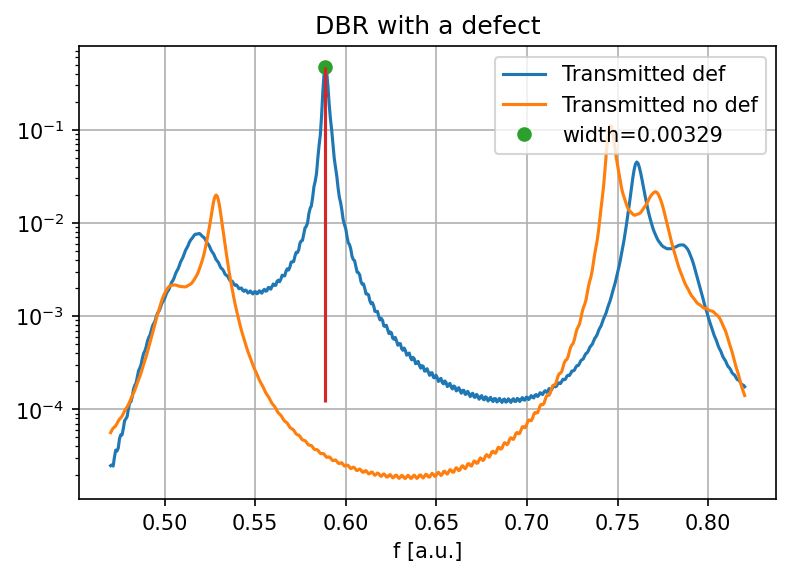

In [5]:
# Find the Peak

peak, properties = sp.find_peaks(straight_tr_fl_2, prominence = (0.3, None), width = [None, 10])

peak = peak[0]

fl_fr = np.array(fl_fr)

# plot the fluxes

fig = plt.figure(dpi = 150)

plt.plot(fl_fr, np.abs(straight_tr_fl_2), label="Transmitted def")
plt.plot(fl_fr, np.abs(straight_tr_fl), label="Transmitted no def")
plt.plot(fl_fr[peak], np.abs(straight_tr_fl_2)[peak], "o", label='width=%.5f' % (properties["widths"][0] * (fl_fr[1]-fl_fr[0]), ) )
plt.vlines(x=fl_fr[peak], ymin=straight_tr_fl_2[peak]-properties["prominences"], ymax=straight_tr_fl_2[peak], color = "C3")
plt.hlines(y=properties["width_heights"], xmin=fl_fr[int(np.ceil(properties["left_ips"][0]))], xmax=fl_fr[int(np.floor(properties["right_ips"][0]))], color="C3")
plt.xlabel("f [a.u.]")
plt.yscale("log")
plt.title("DBR with a defect")
plt.legend()
plt.grid()

plt.savefig("dbr_with_defect.png", dpi = 150, format = "png")

plt.show()


# Now we do it one more time... with 2 defects

-----------
Initializing structure...
time for choose_chunkdivision = 0.000213861 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 16
     block, center = (1.68667,0,0)
          size (5.37333,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.586667,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (-0.173333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (0.24,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (0.653333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          diel

FloatProgress(value=0.0, description='0% done ', max=428.5714282989502)

Meep progress: 192.71875/428.5714282989502 = 45.0% done in 4.0s, 4.9s to go
on time step 6177 (time=193.031), 0.000647845 s/step
Meep progress: 407.34375/428.5714282989502 = 95.0% done in 8.0s, 0.4s to go
on time step 13052 (time=407.875), 0.000581849 s/step
run 0 finished at t = 428.59375 (13715 timesteps)


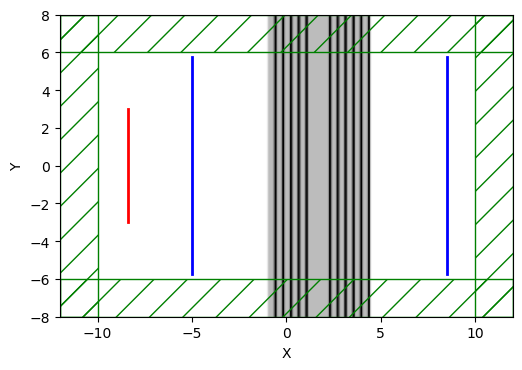

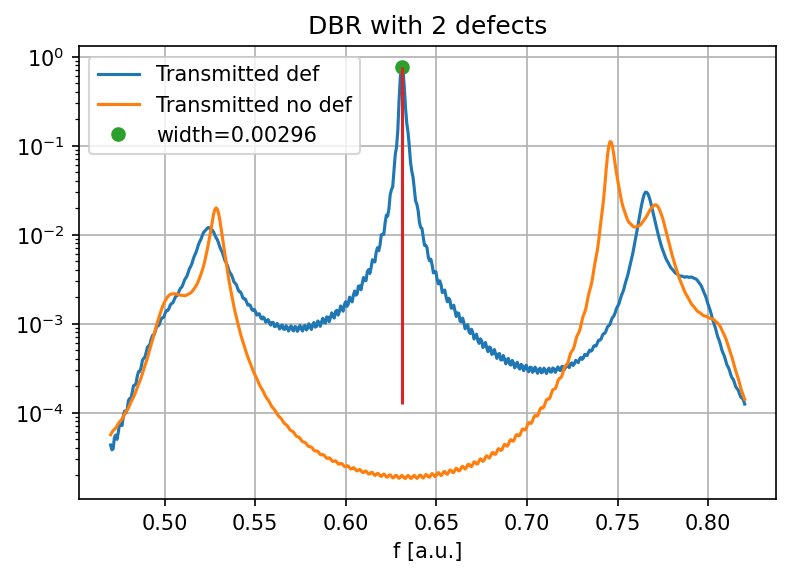

In [35]:
# First, reset meep 

sim.reset_meep()

n_low = 1.5
n_high = 2.4

# Now we define the geomtry. This has to be done iteratively. 1st layer at low index. 

# First, make a block of index n_low

resolution = 18

geometry = [mp.Block(
           mp.Vector3(thck, mp.inf, mp.inf), #
           center = mp.Vector3((dpml + space_front + thck/2) - sx/2 +1,0,0),  
           material = mp.Medium(index = n_low)) ] 


for jj in range(0, n_p):
    
    if (jj != 6 and jj !=5) : 
    
        geometry.append( 
            mp.Block(
               mp.Vector3(l_high, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + (jj+1)*period) -sx/2 +1, 0,0),  
               material = mp.Medium(index = n_high))
        )



# Now define a source

sources = [mp.Source(mp.GaussianSource(frequency=freq, fwidth = df), # Type of source
                     component = mp.Ez, 
                     size = mp.Vector3(0,6,0),
                     center = mp.Vector3(-sx/2 + 1.8*dpml,0))] # Position

# Boundary condition, we use PML layer

pml_layer = [mp.PML(dpml) ] 

# Define Simulation

sim = mp.Simulation(
      cell_size = cell,
      boundary_layers = pml_layer,
      geometry = geometry,
      sources = sources,
      resolution = res)

# Define Flux region for Transmitted Field

tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 1.5, 0, 0), size = mp.Vector3(0,11.5,0) )
trans = sim.add_flux(freq, df, nfreq, tr_fr)

re_fr = mp.FluxRegion(center=mp.Vector3(-sx/2 + dpml + 5, 0, 0), size = mp.Vector3(0,11.5,0) )
refl = sim.add_flux(freq, df, nfreq, re_fr)

sim.load_minus_flux_data(refl, str_re_data)

# Run Simulation

sim.run(until_after_sources=400) 

# Now Get Fluxes

straight_tr_fl_2 = mp.get_fluxes(trans)
straight_re_fl_2 = mp.get_fluxes(refl)
fl_fr = mp.get_flux_freqs(refl)

# plot the dielectric structure 

plt.figure(dpi=100)
sim.plot2D()
plt.show()

# Find the Peak

peak, properties = sp.find_peaks(straight_tr_fl_2, prominence = (0.3, None), width = [None, 10])

peak = peak[0]

fl_fr = np.array(fl_fr)

# plot the fluxes

fig = plt.figure(dpi = 150)

plt.plot(fl_fr, np.abs(straight_tr_fl_2), label="Transmitted def")
plt.plot(fl_fr, np.abs(straight_tr_fl), label="Transmitted no def")
plt.plot(fl_fr[peak], np.abs(straight_tr_fl_2)[peak], "o", label='width=%.5f' % (properties["widths"][0] * (fl_fr[1]-fl_fr[0]), ) )
plt.vlines(x=fl_fr[peak], ymin=straight_tr_fl_2[peak]-properties["prominences"], ymax=straight_tr_fl_2[peak], color = "C3")
plt.hlines(y=properties["width_heights"], xmin=fl_fr[int(np.ceil(properties["left_ips"][0]))], xmax=fl_fr[int(np.floor(properties["right_ips"][0]))], color="C3")
plt.xlabel("f [a.u.]")
plt.yscale("log")
plt.title("DBR with 2 defects")
plt.legend()
plt.grid()

plt.savefig("dbr_with_2_defects.png", dpi = 150, format = "png")

plt.show()



# And one more, with four of them 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 16
     block, center = (1.68667,0,0)
          size (5.37333,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.586667,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (-0.173333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (0.24,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (0.653333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          diel

FloatProgress(value=0.0, description='0% done ', max=428.5714282989502)

Meep progress: 189.625/428.5714282989502 = 44.2% done in 4.0s, 5.0s to go
on time step 6075 (time=189.844), 0.000658457 s/step
Meep progress: 391.34375/428.5714282989502 = 91.3% done in 8.0s, 0.8s to go
on time step 12533 (time=391.656), 0.000619552 s/step
run 0 finished at t = 428.59375 (13715 timesteps)


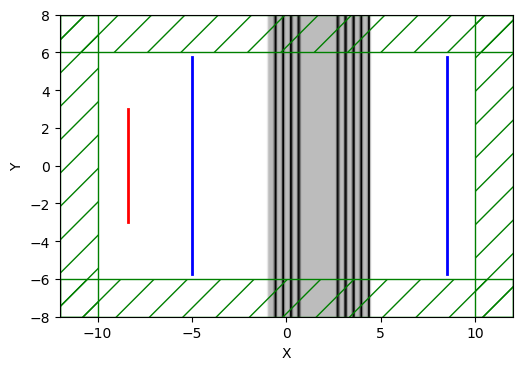

In [36]:
# First, reset meep 

sim.reset_meep()

n_low = 1.5
n_high = 2.4

# Now we define the geomtry. This has to be done iteratively. 1st layer at low index. 

# First, make a block of index n_low

resolution = 18

geometry = [mp.Block(
           mp.Vector3(thck, mp.inf, mp.inf), #
           center = mp.Vector3((dpml + space_front + thck/2) - sx/2 +1,0,0),  
           material = mp.Medium(index = n_low)) ] 


for jj in range(0, n_p):
    
    if (jj != 4 and jj != 6 and jj !=5 and jj != 7) : 
    
        geometry.append( 
            mp.Block(
               mp.Vector3(l_high, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + (jj+1)*period) -sx/2 +1, 0,0),  
               material = mp.Medium(index = n_high))
        )



# Now define a source

sources = [mp.Source(mp.GaussianSource(frequency=freq, fwidth = df), # Type of source
                     component = mp.Ez, 
                     size = mp.Vector3(0,6,0),
                     center = mp.Vector3(-sx/2 + 1.8*dpml,0))] # Position

# Boundary condition, we use PML layer

pml_layer = [mp.PML(dpml) ] 

# Define Simulation

sim = mp.Simulation(
      cell_size = cell,
      boundary_layers = pml_layer,
      geometry = geometry,
      sources = sources,
      resolution = res)

# Define Flux region for Transmitted Field

tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 1.5, 0, 0), size = mp.Vector3(0,11.5,0) )
trans = sim.add_flux(freq, df, nfreq, tr_fr)

re_fr = mp.FluxRegion(center=mp.Vector3(-sx/2 + dpml + 5, 0, 0), size = mp.Vector3(0,11.5,0) )
refl = sim.add_flux(freq, df, nfreq, re_fr)

sim.load_minus_flux_data(refl, str_re_data)

# Run Simulation

sim.run(until_after_sources=400) 

# Now Get Fluxes

straight_tr_fl_2 = mp.get_fluxes(trans)
straight_re_fl_2 = mp.get_fluxes(refl)
fl_fr = mp.get_flux_freqs(refl)

# plot the dielectric structure 

plt.figure(dpi=100)
sim.plot2D()
plt.show()



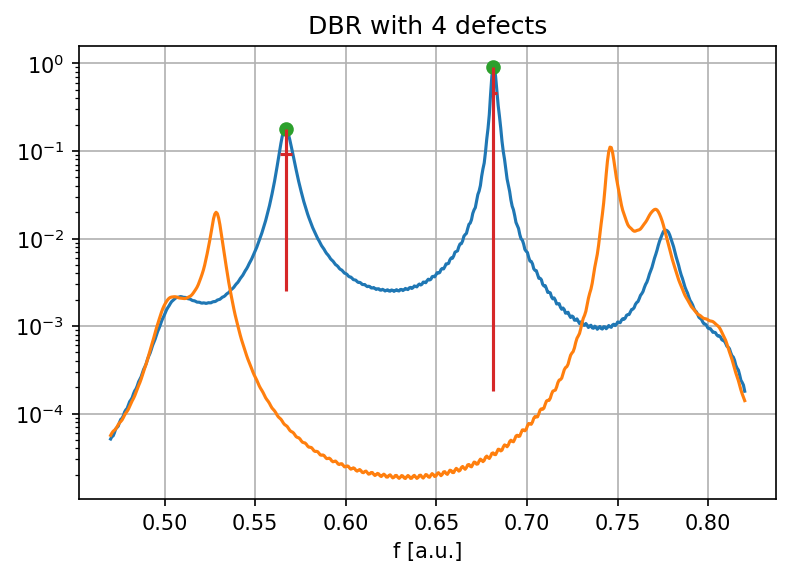

In [37]:
# Find the Peak

peaks, properties = sp.find_peaks(straight_tr_fl_2, prominence = (0.1,1), width = [5, None])

fl_fr = np.array(fl_fr)

# plot the fluxes

fig = plt.figure(dpi = 150)

plt.plot(fl_fr, np.abs(straight_tr_fl_2), label="Transmitted def")
plt.plot(fl_fr, np.abs(straight_tr_fl), label="Transmitted no def")
plt.plot(fl_fr[peaks], np.abs(straight_tr_fl_2)[peaks], "o" )
plt.vlines(x=fl_fr[peaks][0], ymin=straight_tr_fl_2[peaks[0]]-properties["prominences"][0], ymax=straight_tr_fl_2[peaks[0]], color = "C3")
plt.vlines(x=fl_fr[peaks][1], ymin=straight_tr_fl_2[peaks[1]]-properties["prominences"][1], ymax=straight_tr_fl_2[peaks[1]], color = "C3")
plt.hlines(y=properties["width_heights"][0], xmin=fl_fr[int(np.ceil(properties["left_ips"][0]))], xmax=fl_fr[int(np.floor(properties["right_ips"][0]))], color="C3")
plt.hlines(y=properties["width_heights"][1], xmin=fl_fr[int(np.ceil(properties["left_ips"][1]))], xmax=fl_fr[int(np.floor(properties["right_ips"][1]))], color="C3")
plt.xlabel("f [a.u.]")
plt.yscale("log")
plt.title("DBR with 4 defects")
plt.grid()

plt.savefig("dbr_with_4_defects.png", dpi = 150, format = "png")

plt.show()